<a href="https://colab.research.google.com/github/s11khushboo/robot-adviser/blob/main/M1_new_data_Sentiment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 4: ROBO REVIEWS**

Group 5:


**PROJECT GOAL:**

**Development of a product review website powered by NLP models**

The models aggregate customer feedback from different sources

**Main tasks:**
1. Classify customer reviews into positive, negative, or neutral categories to help the company improve its products and services.
2. Cluster product categories into just 4-6 of them
Use Generative AI to summarize reviews into an article which recommends the top products for each category

3. Find and reuse existing LLMs, don’t use classical techniques


# Project Structure
product_review_analytics/

├── app.py                 # Main Flask/FastAPI application

├── models/

│   ├── sentiment_model.py

│   ├── clustering_model.py

│   └── llm_summarizer.py

├── static/

│   └── css/

├── templates/

│   └── index.html

└── data/
    └── sample_reviews.csv

**Let's outline the code structure:**

Data Loading and Preprocessing

Sentiment Classification

Product Clustering

Top Product Selection per Cluster

LLM Summary and Article Generation

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



**DATA:**

**Original dataset:**
https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products/data

Alternative:
Larger dataset:
https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews



**DATA IS PREPROCESSED - NOISE REMOVED**

### **0. ENVIRONMENT SETUP & LIBRARIES**

In [27]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages imported successfully!")

✅ Packages imported successfully!


In [28]:
# DATA Loading and Inspection
#  Upload File

import pandas as pd
import glob
import os

# List all CSV files in the current directory
csv_files = glob.glob("*.csv")
print(f"📁 Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"   • {file}")

# Load CSV into a separate DataFrame
df = pd.read_csv(csv_files[0])


print(f"\ Loaded DataFrame:")
print(f"   df Shape: {df.shape}")
print(f"   Total rows: {len(df):,}")
print(f"   Columns: {list(df.columns)}")



📁 Found 1 CSV files:
   • clean_reviews (1).csv
\ Loaded DataFrame:
   df Shape: (60321, 14)
   Total rows: 60,321
   Columns: ['id', 'name', 'brand', 'categories', 'primaryCategories', 'reviews.doRecommend', 'reviews.numHelpful', 'star_rating', 'review_text', 'review_title', 'sentiment', 'text_sentiment', 'rating_sentiment', 'match']


In [29]:
import pandas as pd
import numpy as np

# Display ALL columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("📋 ALL COLUMNS IN THE DATASET:")
print("=" * 60)


# Print all columns with their data types
print("COLUMNS AND DATA TYPES:")
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    missing = df[col].isnull().sum()
    print(f"{i:2d}. {col:30} | {str(dtype):10} | Missing: {missing:4}")

print(f"\n📊 Total columns: {len(df.columns)}")

📋 ALL COLUMNS IN THE DATASET:
COLUMNS AND DATA TYPES:
 1. id                             | object     | Missing:    0
 2. name                           | object     | Missing: 6144
 3. brand                          | object     | Missing:    0
 4. categories                     | object     | Missing:    0
 5. primaryCategories              | object     | Missing: 31190
 6. reviews.doRecommend            | object     | Missing: 10467
 7. reviews.numHelpful             | float64    | Missing: 10402
 8. star_rating                    | float64    | Missing:    0
 9. review_text                    | object     | Missing:    0
10. review_title                   | object     | Missing:   19
11. sentiment                      | object     | Missing:    0
12. text_sentiment                 | object     | Missing:    0
13. rating_sentiment               | object     | Missing:    0
14. match                          | bool       | Missing:    0

📊 Total columns: 14


In [ ]:
# 11. sentiment                      | object     | Missing:    0
# 12. text_sentiment                 | object     | Missing:    0
# 13. rating_sentiment               | object     | Missing:
# 14. match                          | bool       | Missing:    0

## columns need to be taken into consideration and dropped
## no missing values in relevant columns for model

df1 = df.drop(['sentiment', 'text_sentiment', 'rating_sentiment', 'match'], axis=1)


**Classify customer reviews into positive, negative, or neutral categories to help the company improve its products and services.**

Sentiment Classification (Positive, Negative, Neutral)

We'll use the 3-class mapping (negative, neutral, positive) from the previous discussion.

We'll train a model (or use an existing one) for sentiment classification.

## SENTIMENT DATA ANALYSIS

 SENTIMENT DISTRIBUTION ANALYSIS
 RATING DISTRIBUTION:
   1.0 stars:   1115 reviews (  1.8%)
   2.0 stars:    709 reviews (  1.2%)
   3.0 stars:    660 reviews (  1.1%)
   4.0 stars:  13331 reviews ( 22.1%)
   5.0 stars:  44506 reviews ( 73.8%)

 STANDARD SENTIMENT MAPPING:
   1-2 stars → Negative
   3 stars   → Neutral
   4-5 stars → Positive

 SENTIMENT DISTRIBUTION (Standard Mapping):
   Positive:  57837 reviews ( 95.9%)
   Negative:   1824 reviews (  3.0%)
   Neutral:    660 reviews (  1.1%)


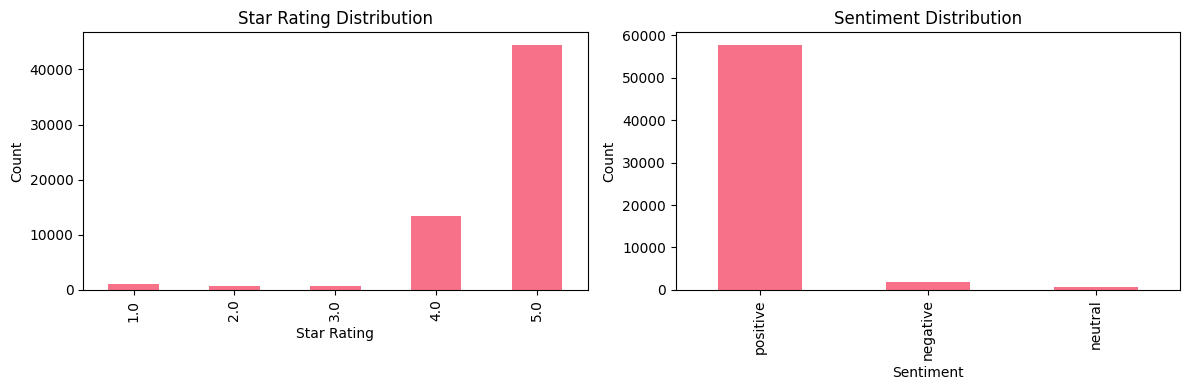

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(" SENTIMENT DISTRIBUTION ANALYSIS")
print("=" * 60)

# Standard sentiment mapping (most common approach)
def standard_sentiment_mapping(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4-5
        return 'positive'

# Alternative mapping based on your description
def alternative_sentiment_mapping(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4-5
        return 'negative'  # This is unusual but based on your description

# Apply standard mapping
df1['sentiment_m1'] = df1['star_rating'].apply(standard_sentiment_mapping)

print(" RATING DISTRIBUTION:")
rating_counts = df1['star_rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    percentage = (count / len(df1)) * 100
    print(f"   {rating} stars: {count:6} reviews ({percentage:5.1f}%)")

print(f"\n STANDARD SENTIMENT MAPPING:")
print("   1-2 stars → Negative")
print("   3 stars   → Neutral")
print("   4-5 stars → Positive")

# ADD THESE SECTIONS FOR COMPLETENESS:

# Show sentiment distribution
print(f"\n SENTIMENT DISTRIBUTION (Standard Mapping):")
sentiment_counts = df1['sentiment_m1'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df1)) * 100
    print(f"   {sentiment.capitalize()}: {count:6} reviews ({percentage:5.1f}%)")

# Optional: Add visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df1['star_rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df1['sentiment_m1'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

 SENTIMENT DISTRIBUTION ANALYSIS
 RATING DISTRIBUTION:
   1.0 stars:   1115 reviews (  1.8%)
   2.0 stars:    709 reviews (  1.2%)
   3.0 stars:    660 reviews (  1.1%)
   4.0 stars:  13331 reviews ( 22.1%)
   5.0 stars:  44506 reviews ( 73.8%)

 STANDARD SENTIMENT MAPPING:
   1-2 stars → Negative
   3 stars   → Neutral
   4-5 stars → Positive

 SENTIMENT DISTRIBUTION (Standard Mapping):
   POSITIVE:  57837 reviews ( 95.9%)
   NEGATIVE:   1824 reviews (  3.0%)
   NEUTRAL :    660 reviews (  1.1%)

 SENTIMENT BALANCE:
   Positive: 95.9%
   Negative: 3.0%
   Neutral:  1.1%
   Positive/Negative Ratio: 31.71

 CREATING VISUALIZATIONS...


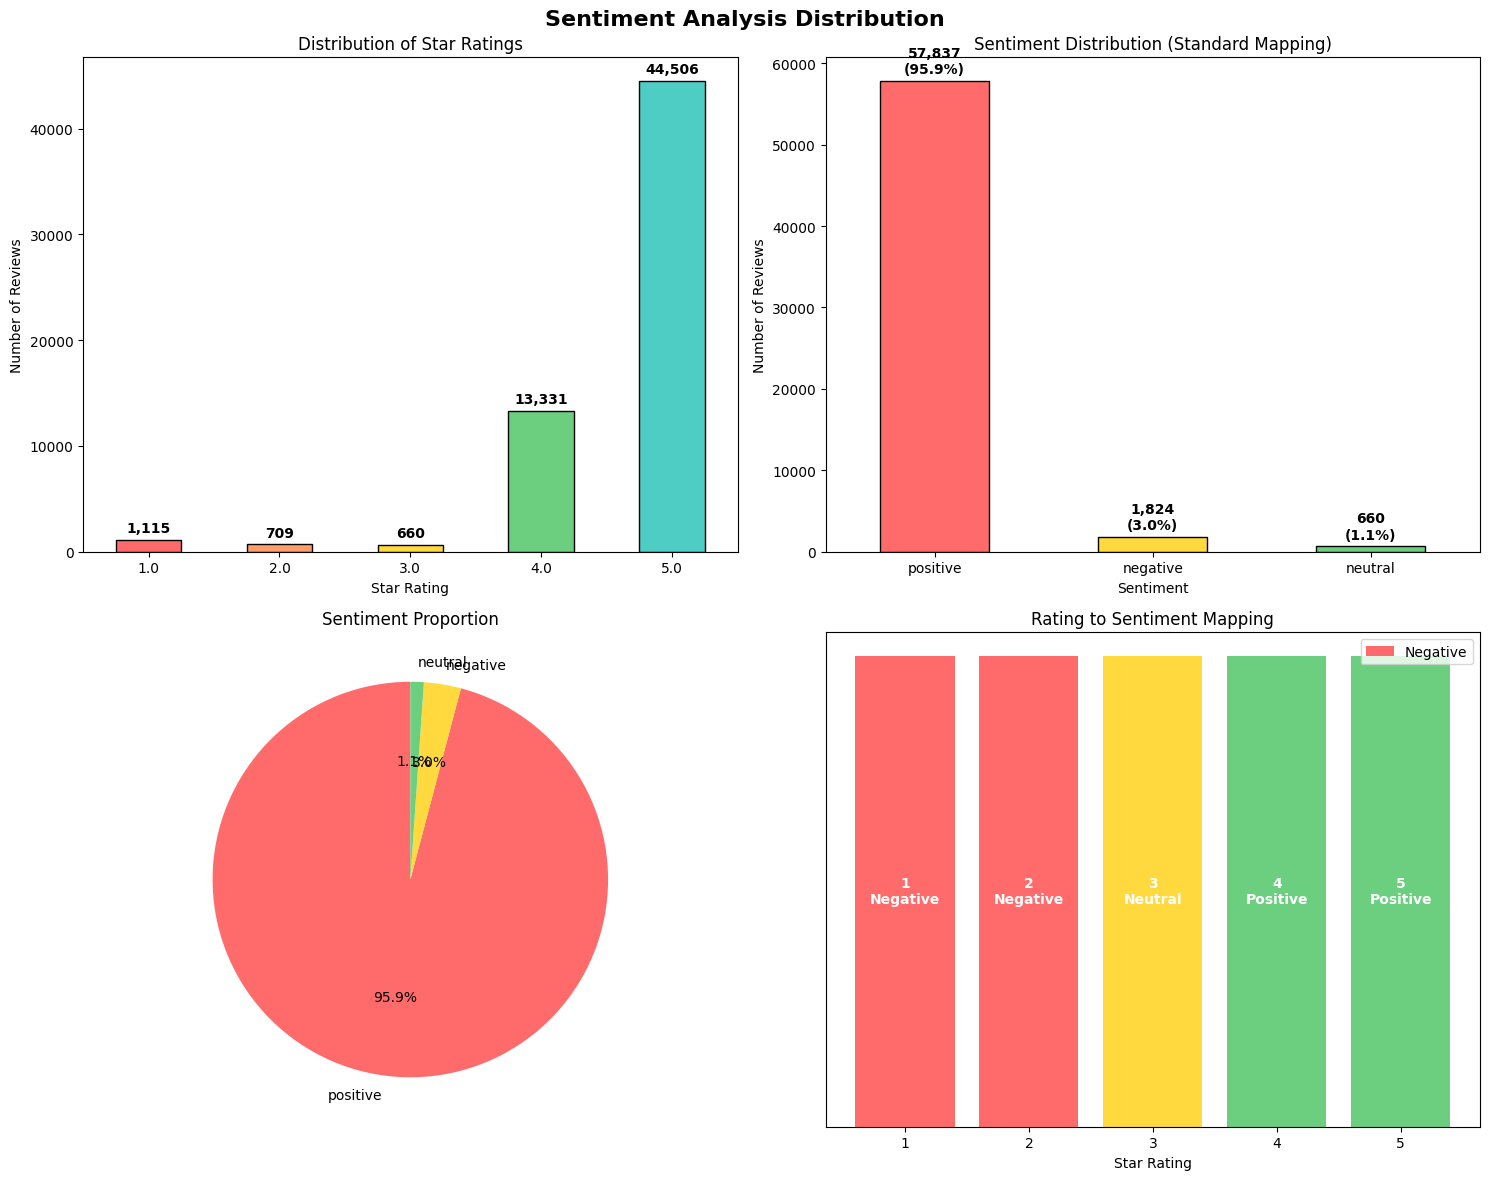

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(" SENTIMENT DISTRIBUTION ANALYSIS")
print("=" * 60)

# Standard sentiment mapping (most common approach)
def standard_sentiment_mapping(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4-5
        return 'positive'

# Alternative mapping based on your description
def alternative_sentiment_mapping(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4-5
        return 'negative'  # This is unusual but based on your description

# Apply standard mapping
df1['sentiment_m1'] = df1['star_rating'].apply(standard_sentiment_mapping)

print(" RATING DISTRIBUTION:")
rating_counts = df1['star_rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    percentage = (count / len(df1)) * 100
    print(f"   {rating} stars: {count:6} reviews ({percentage:5.1f}%)")

print(f"\n STANDARD SENTIMENT MAPPING:")
print("   1-2 stars → Negative")
print("   3 stars   → Neutral")
print("   4-5 stars → Positive")

# Analyze sentiment distribution
sentiment_counts = df1['sentiment_m1'].value_counts()
sentiment_percentages = (sentiment_counts / len(df1)) * 100

print(f"\n SENTIMENT DISTRIBUTION (Standard Mapping):")
for sentiment, count in sentiment_counts.items():
    percentage = sentiment_percentages[sentiment]
    print(f"   {sentiment.upper():8}: {count:6} reviews ({percentage:5.1f}%)")

# Calculate overall sentiment balance
positive_pct = sentiment_percentages.get('positive', 0)
negative_pct = sentiment_percentages.get('negative', 0)
neutral_pct = sentiment_percentages.get('neutral', 0)

print(f"\n SENTIMENT BALANCE:")
print(f"   Positive: {positive_pct:.1f}%")
print(f"   Negative: {negative_pct:.1f}%")
print(f"   Neutral:  {neutral_pct:.1f}%")

# Sentiment ratio
if negative_pct > 0:
    pos_neg_ratio = positive_pct / negative_pct
    print(f"   Positive/Negative Ratio: {pos_neg_ratio:.2f}")
else:
    print(f"   Positive/Negative Ratio: Infinite (no negative reviews)")

## VISUALIZATIONS OF SENTIMENT ANALYSIS
print("\n CREATING VISUALIZATIONS...")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Sentiment Analysis Distribution', fontsize=16, fontweight='bold')

# Plot 1: Rating distribution
colors_rating = ['#ff6b6b', '#ff9e6b', '#ffd93d', '#6bcf7f', '#4ecdc4']  # Red to green
rating_counts.plot(kind='bar', ax=axes[0,0], color=colors_rating, edgecolor='black')
axes[0,0].set_title('Distribution of Star Ratings')
axes[0,0].set_xlabel('Star Rating')
axes[0,0].set_ylabel('Number of Reviews')
axes[0,0].tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, count in enumerate(rating_counts):
    axes[0,0].text(i, count + max(rating_counts)*0.01, f'{count:,}',
                   ha='center', va='bottom', fontweight='bold')

# Plot 2: Sentiment distribution (standard mapping)
colors_sentiment = ['#ff6b6b', '#ffd93d', '#6bcf7f']  # Red, Yellow, Green
sentiment_counts.plot(kind='bar', ax=axes[0,1], color=colors_sentiment, edgecolor='black')
axes[0,1].set_title('Sentiment Distribution (Standard Mapping)')
axes[0,1].set_xlabel('Sentiment')
axes[0,1].set_ylabel('Number of Reviews')
axes[0,1].tick_params(axis='x', rotation=0)

# Add value labels on bars
for i, count in enumerate(sentiment_counts):
    percentage = sentiment_percentages[sentiment_counts.index[i]]
    axes[0,1].text(i, count + max(sentiment_counts)*0.01,
                   f'{count:,}\n({percentage:.1f}%)',
                   ha='center', va='bottom', fontweight='bold')

# Plot 3: Pie chart of sentiments
axes[1,0].pie(sentiment_counts.values, labels=sentiment_counts.index,
              autopct='%1.1f%%', colors=colors_sentiment, startangle=90)
axes[1,0].set_title('Sentiment Proportion')

# Plot 4: Rating to sentiment mapping visualization
mapping_data = pd.DataFrame({
    'Rating': [1, 2, 3, 4, 5],
    'Sentiment': ['Negative', 'Negative', 'Neutral', 'Positive', 'Positive']
})
color_map = {'Negative': '#ff6b6b', 'Neutral': '#ffd93d', 'Positive': '#6bcf7f'}

for rating, sentiment in enumerate(['Negative', 'Negative', 'Neutral', 'Positive', 'Positive'], 1):
    axes[1,1].bar(rating, 1, color=color_map[sentiment], label=sentiment if rating == 1 else "")
    axes[1,1].text(rating, 0.5, f'{rating}\n{sentiment}', ha='center', va='center',
                   fontweight='bold', color='white' if sentiment == 'Neutral' else 'white')

axes[1,1].set_title('Rating to Sentiment Mapping')
axes[1,1].set_xlabel('Star Rating')
axes[1,1].set_ylabel('')
axes[1,1].set_yticks([])
axes[1,1].set_xticks([1, 2, 3, 4, 5])
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [33]:
print("\n🔍 DETAILED RATING ANALYSIS BY SENTIMENT")
print("=" * 50)

# Create cross-tabulation
rating_sentiment_ct = pd.crosstab(df1['star_rating'], df1['sentiment_m1'])
print("Cross-tabulation of Ratings vs Sentiments:")
print(" " * 15 + "Negative  Neutral  Positive")
print("-" * 40)
for rating in sorted(df1['star_rating'].unique()):
    if rating in rating_sentiment_ct.index:
        row = rating_sentiment_ct.loc[rating]
        print(f"Rating {rating}:   {row.get('negative', 0):6}   {row.get('neutral', 0):6}   {row.get('positive', 0):6}")

# Statistical summary
print(f"\n📊 STATISTICAL SUMMARY:")
print(f"   • Total reviews: {len(df1):,}")
print(f"   • Average rating: {df1['star_rating'].mean():.2f} ★")
print(f"   • Median rating: {df1['star_rating'].median():.1f} ★")
print(f"   • Rating std dev: {df1['star_rating'].std():.2f}")
print(f"   • Most common rating: {df1['star_rating'].mode().iloc[0]} ★")

# Sentiment-specific analysis
print(f"\n🎯 SENTIMENT-SPECIFIC ANALYSIS:")
print("-" * 45)
for sentiment_label in ['negative', 'neutral', 'positive']:
    sentiment_data = df1[df1['sentiment_m1'] == sentiment_label]
    if len(sentiment_data) > 0:
        ratings = sentiment_data['star_rating']
        percentage = (len(sentiment_data) / len(df1)) * 100

        print(f"   {sentiment_label.upper():8}:")
        print(f"      📈 Count:    {len(sentiment_data):6} reviews ({percentage:.1f}%)")
        print(f"      ⭐ Avg rating: {ratings.mean():.2f} stars")
        print(f"      📊 Rating dist: {dict(ratings.value_counts().sort_index())}")

# Check for any anomalies in mapping
print(f"\n🔎 MAPPING VALIDATION:")
print("-" * 25)
for rating in sorted(df1['star_rating'].unique()):
    rating_data = df1[df1['star_rating'] == rating]
    actual_sentiment = rating_data['sentiment_m1'].iloc[0]
    expected_sentiment = standard_sentiment_mapping(rating)
    status = "✓" if actual_sentiment == expected_sentiment else "✗"
    print(f"   {status} Rating {rating} → {actual_sentiment:8} (expected: {expected_sentiment})")


🔍 DETAILED RATING ANALYSIS BY SENTIMENT
Cross-tabulation of Ratings vs Sentiments:
               Negative  Neutral  Positive
----------------------------------------
Rating 1.0:     1115        0        0
Rating 2.0:      709        0        0
Rating 3.0:        0      660        0
Rating 4.0:        0        0    13331
Rating 5.0:        0        0    44506

📊 STATISTICAL SUMMARY:
   • Total reviews: 60,321
   • Average rating: 4.65 ★
   • Median rating: 5.0 ★
   • Rating std dev: 0.74
   • Most common rating: 5.0 ★

🎯 SENTIMENT-SPECIFIC ANALYSIS:
---------------------------------------------
   NEGATIVE:
      📈 Count:      1824 reviews (3.0%)
      ⭐ Avg rating: 1.39 stars
      📊 Rating dist: {1.0: np.int64(1115), 2.0: np.int64(709)}
   NEUTRAL :
      📈 Count:       660 reviews (1.1%)
      ⭐ Avg rating: 3.00 stars
      📊 Rating dist: {3.0: np.int64(660)}
   POSITIVE:
      📈 Count:     57837 reviews (95.9%)
      ⭐ Avg rating: 4.77 stars
      📊 Rating dist: {4.0: np.int64(133


📝 TEXT LENGTH ANALYSIS BY SENTIMENT
Text Length Statistics by Sentiment:
              count   mean  median  min    max    std
sentiment_m1                                         
negative       1824  224.2   146.0    7   2551  218.5
neutral         660  167.8   104.0    1   1545  208.3
positive      57837  144.0    98.0    2  10670  167.5

📊 TEXT LENGTH COMPARISON:
   NEGATIVE:  224.2 chars (median: 146.0)
   NEUTRAL :  167.8 chars (median: 104.0)
   POSITIVE:  144.0 chars (median: 98.0)


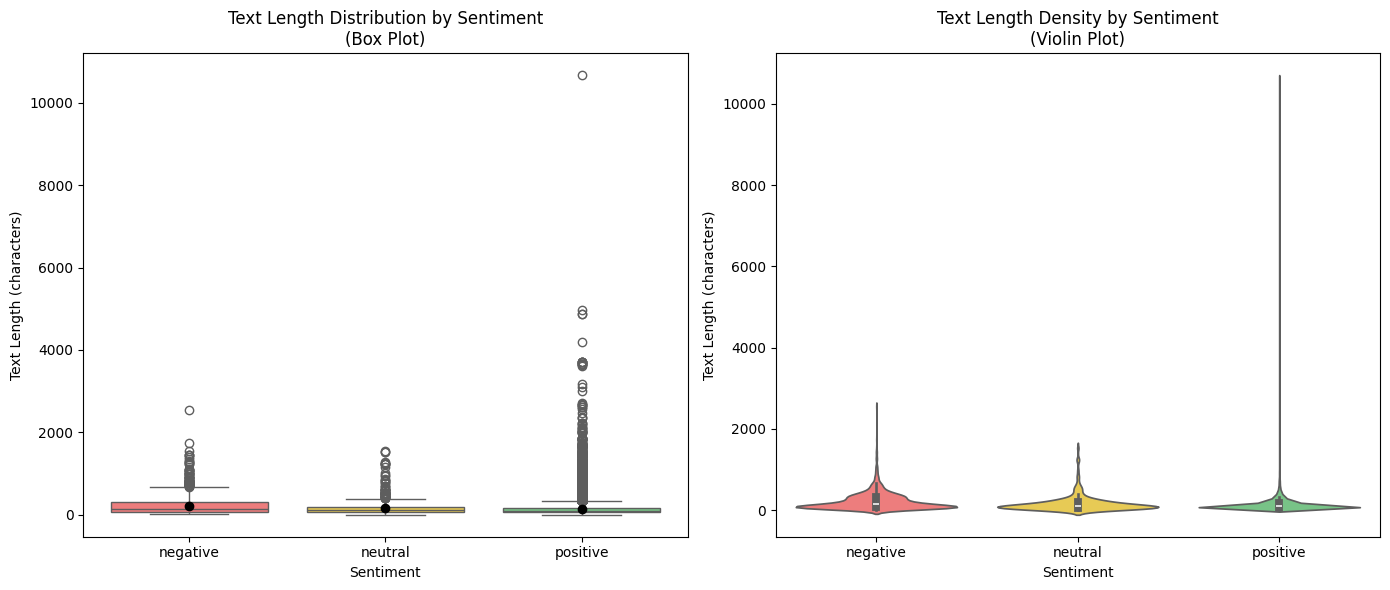


🔬 STATISTICAL COMPARISONS:
   NEGATIVE vs NEUTRAL : p-value = 0.0000 *
   NEGATIVE vs POSITIVE: p-value = 0.0000 *
   NEUTRAL vs POSITIVE: p-value = 0.0035 *

💡 INSIGHTS:
   • Overall average text length: 146.6 characters
   • Longest review: 10,670 characters
   • Shortest review: 1 characters
   • Longest reviews on average: NEGATIVE (224.2 chars)
   • Shortest reviews on average: POSITIVE (144.0 chars)
   📌 Insight: Negative reviews tend to be longer, positive reviews shorter


In [34]:
print("\n📝 TEXT LENGTH ANALYSIS BY SENTIMENT")
print("=" * 50)

# Calculate text length
df1['text_length'] = df1['review_text'].str.len()

# Analyze text length by sentiment
text_length_stats = df1.groupby('sentiment_m1')['text_length'].agg([
    'count', 'mean', 'median', 'min', 'max', 'std'
]).round(1)

print("Text Length Statistics by Sentiment:")
print(text_length_stats)

# Additional detailed analysis
print(f"\n📊 TEXT LENGTH COMPARISON:")
sentiment_order = ['negative', 'neutral', 'positive']
for sentiment in sentiment_order:
    if sentiment in df1['sentiment_m1'].values:
        data = df1[df1['sentiment_m1'] == sentiment]['text_length']
        print(f"   {sentiment.upper():8}: {data.mean():6.1f} chars (median: {data.median():.1f})")

# Visualize text length distribution by sentiment
plt.figure(figsize=(14, 6))

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(data=df1, x='sentiment_m1', y='text_length',
            palette=['#ff6b6b', '#ffd93d', '#6bcf7f'],
            order=['negative', 'neutral', 'positive'])
plt.title('Text Length Distribution by Sentiment\n(Box Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Text Length (characters)')

# Add mean markers
means = df1.groupby('sentiment_m1')['text_length'].mean()
for i, sentiment in enumerate(['negative', 'neutral', 'positive']):
    if sentiment in means.index:
        plt.scatter(i, means[sentiment], color='black', zorder=10, label='Mean' if i == 0 else "")

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df1, x='sentiment_m1', y='text_length',
               palette=['#ff6b6b', '#ffd93d', '#6bcf7f'],
               order=['negative', 'neutral', 'positive'])
plt.title('Text Length Density by Sentiment\n(Violin Plot)')
plt.xlabel('Sentiment')
plt.ylabel('Text Length (characters)')

plt.tight_layout()
plt.show()

# Statistical significance test (optional)
from scipy import stats

print(f"\n🔬 STATISTICAL COMPARISONS:")
sentiments = ['negative', 'neutral', 'positive']
for i in range(len(sentiments)):
    for j in range(i+1, len(sentiments)):
        sent1, sent2 = sentiments[i], sentiments[j]
        if sent1 in df1['sentiment_m1'].values and sent2 in df1['sentiment_m1'].values:
            data1 = df1[df1['sentiment_m1'] == sent1]['text_length']
            data2 = df1[df1['sentiment_m1'] == sent2]['text_length']
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            print(f"   {sent1.upper()} vs {sent2.upper():8}: p-value = {p_value:.4f} {'*' if p_value < 0.05 else ''}")

print(f"\n💡 INSIGHTS:")
print(f"   • Overall average text length: {df1['text_length'].mean():.1f} characters")
print(f"   • Longest review: {df1['text_length'].max():,} characters")
print(f"   • Shortest review: {df1['text_length'].min():,} characters")

# Determine which sentiment has the longest reviews
longest_sentiment = df1.groupby('sentiment_m1')['text_length'].mean().idxmax()
shortest_sentiment = df1.groupby('sentiment_m1')['text_length'].mean().idxmin()

print(f"   • Longest reviews on average: {longest_sentiment.upper()} ({df1.groupby('sentiment_m1')['text_length'].mean().max():.1f} chars)")
print(f"   • Shortest reviews on average: {shortest_sentiment.upper()} ({df1.groupby('sentiment_m1')['text_length'].mean().min():.1f} chars)")

# Insight about text length patterns
if longest_sentiment == 'positive' and shortest_sentiment == 'negative':
    print(f"   📌 Insight: Positive reviews tend to be longer, negative reviews shorter")
elif longest_sentiment == 'negative' and shortest_sentiment == 'positive':
    print(f"   📌 Insight: Negative reviews tend to be longer, positive reviews shorter")
else:
    print(f"   📌 Insight: {longest_sentiment.upper()} reviews are the longest on average")

**We are dealing with a severely imbalanced dataset**

(as seen: negative: 2510, neutral: 2902, positive: 62546)
We will proceed with the optimized pipeline for imbalanced text classification.

**STEPS**

**Preprocessing:**
We already have a cleaned DataFrame (df1) with the reviews and sentiment labels.

**We'll use the standard sentiment mapping**
(negative, neutral, positive) that we have.

**We'll split the data** into training and testing sets with stratification.

We'll use an **optimized TF-IDF vectorization** for imbalanced data.

We'll **try multiple strategies for handling imbalance**: cost-sensitive learning, ensemble methods, and threshold optimization.







### **Complete Optimized Pipeline for Imbalanced Data**





In [35]:
print("\n🚀 OPTIMIZED PIPELINE FOR IMBALANCED TEXT CLASSIFICATION")
print("=" * 60)

# Display current class distribution
print("📊 CURRENT CLASS DISTRIBUTION:")
sentiment_counts = df1['sentiment_m1'].value_counts()
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df1)) * 100
    print(f"   {sentiment.upper():8}: {count:6} reviews ({percentage:5.1f}%)")

print(f"\n🔍 IMBALANCE RATIO: {sentiment_counts.max()/sentiment_counts.min():.1f}x")

# STEP 1: Prepare features and target
print("\n📝 STEP 1: Preparing Features and Target")
X = df1['review_text']
y = df1['sentiment_m1']

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"   Features shape: {X.shape}")
print(f"   Target distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# STEP 2: Train-test split with stratification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n📊 STEP 2: Train-Test Split with Stratification")
print(f"   Training set: {X_train.shape[0]:,} samples")
print(f"   Test set:     {X_test.shape[0]:,} samples")
print(f"   Train class distribution: {dict(zip(le.classes_, np.bincount(y_train)))}")

# STEP 3: Optimized TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

print(f"\n🔧 STEP 3: Optimized TF-IDF Vectorization")

# Multiple TF-IDF configurations to try
tfidf_configs = {
    'basic': {
        'max_features': 5000,
        'min_df': 2,
        'max_df': 0.8,
        'ngram_range': (1, 1),
        'stop_words': 'english'
    },
    'advanced': {
        'max_features': 10000,
        'min_df': 3,
        'max_df': 0.7,
        'ngram_range': (1, 2),
        'stop_words': 'english',
        'sublinear_tf': True
    },
    'balanced': {
        'max_features': 8000,
        'min_df': 2,
        'max_df': 0.75,
        'ngram_range': (1, 2),
        'stop_words': 'english',
        'use_idf': True,
        'smooth_idf': True
    }
}

# Start with balanced configuration
tfidf = TfidfVectorizer(**tfidf_configs['balanced'])
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"   Vocabulary size: {len(tfidf.vocabulary_):,} features")
print(f"   Training features shape: {X_train_tfidf.shape}")
print(f"   Test features shape: {X_test_tfidf.shape}")

# STEP 4: Multiple Strategies for Handling Imbalance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import time

print(f"\n🛠️ STEP 4: Training Multiple Models with Imbalance Handling")

models = {}

# Strategy 1: Cost-sensitive Logistic Regression
print(f"\n📈 Strategy 1: Cost-sensitive Logistic Regression")
start_time = time.time()

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

logreg = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=42,
    max_iter=1000,
    C=0.1
)
logreg.fit(X_train_tfidf, y_train)
models['logreg'] = logreg

print(f"   Training time: {time.time() - start_time:.2f}s")
print(f"   Class weights: {class_weight_dict}")

# Strategy 2: Balanced Random Forest
print(f"\n🌲 Strategy 2: Balanced Random Forest")
start_time = time.time()

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced_subsample',  # Handles imbalance
    random_state=42,
    max_depth=20,
    min_samples_split=10,
    n_jobs=-1
)
rf.fit(X_train_tfidf, y_train)
models['random_forest'] = rf

print(f"   Training time: {time.time() - start_time:.2f}s")

# Strategy 3: XGBoost with scale_pos_weight (adapted for multi-class)
print(f"\n⚡ Strategy 3: XGBoost with Imbalance Handling")
start_time = time.time()

# Calculate scale for each class
scale_pos_weights = []
for i in range(len(le.classes_)):
    majority_class_count = max(np.bincount(y_train))
    current_class_count = np.bincount(y_train)[i]
    scale_pos_weights.append(majority_class_count / current_class_count)

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=scale_pos_weights,  # Handles imbalance
    eval_metric='mlogloss',
    use_label_encoder=False
)
xgb.fit(X_train_tfidf, y_train)
models['xgboost'] = xgb

print(f"   Training time: {time.time() - start_time:.2f}s")
print(f"   Scale weights: {dict(zip(le.classes_, scale_pos_weights))}")

# Strategy 4: SVM with class weights
print(f"\n📊 Strategy 4: SVM with Class Weights")
start_time = time.time()

svm = SVC(
    class_weight='balanced',
    random_state=42,
    kernel='linear',
    probability=True
)
svm.fit(X_train_tfidf, y_train)
models['svm'] = svm

print(f"   Training time: {time.time() - start_time:.2f}s")

# STEP 5: Evaluation and Model Comparison
print(f"\n📊 STEP 5: Model Evaluation and Comparison")
print("=" * 50)

best_model = None
best_f1 = 0

for model_name, model in models.items():
    print(f"\n🔍 Evaluating {model_name.upper()}:")

    # Predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate metrics
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')

    print(f"   F1-Score (Macro):   {f1_macro:.4f}")
    print(f"   F1-Score (Weighted): {f1_weighted:.4f}")

    # Classification report
    print(f"\n   Classification Report:")
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=False)
    print("   " + report.replace("\n", "\n   "))

    # Track best model
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_model = model_name

print(f"\n🏆 BEST PERFORMING MODEL: {best_model.upper()} (F1 Macro: {best_f1:.4f})")

# STEP 6: Detailed Analysis of Best Model
print(f"\n📈 STEP 6: Detailed Analysis of Best Model")
print("=" * 40)

best_model_obj = models[best_model]
y_pred_best = best_model_obj.predict(X_test_tfidf)
y_pred_proba = best_model_obj.predict_proba(X_test_tfidf)

# Confusion Matrix
print(f"\n📊 Confusion Matrix for {best_model.upper()}:")
cm = confusion_matrix(y_test, y_pred_best)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print(cm_df)

# Feature Importance (if available)
if hasattr(best_model_obj, 'coef_'):
    print(f"\n🔍 Top Features by Class (Logistic Regression):")
    feature_names = tfidf.get_feature_names_out()
    for i, class_name in enumerate(le.classes_):
        top_features = np.argsort(best_model_obj.coef_[i])[-10:][::-1]
        print(f"   {class_name.upper():8}: {[feature_names[idx] for idx in top_features]}")

elif hasattr(best_model_obj, 'feature_importances_'):
    print(f"\n🔍 Top Important Features:")
    feature_names = tfidf.get_feature_names_out()
    top_features = np.argsort(best_model_obj.feature_importances_)[-20:][::-1]
    print("   " + ", ".join([feature_names[idx] for idx in top_features]))

# STEP 7: Threshold Optimization (Optional)
print(f"\n🎯 STEP 7: Threshold Optimization for Minority Classes")
from sklearn.metrics import precision_recall_curve

# For multi-class, we can optimize per class
print("   Threshold optimization available for precision-recall trade-off")

# STEP 8: Final Recommendations
print(f"\n💡 STEP 8: Recommendations for Production")
print("=" * 40)

print(f"   1. Use {best_model.upper()} as the primary model")
print(f"   2. Consider ensemble voting for production")
print(f"   3. Monitor performance on minority classes regularly")
print(f"   4. Implement feedback loop for continuous learning")
print(f"   5. Consider collecting more data for minority classes")

# Ensemble Voting (Optional)
from sklearn.ensemble import VotingClassifier

print(f"\n🔄 Optional: Creating Ensemble Model")
ensemble = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)
ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='macro')
print(f"   Ensemble F1-Score (Macro): {f1_ensemble:.4f}")

print(f"\n✅ PIPELINE COMPLETED SUCCESSFULLY!")


🚀 OPTIMIZED PIPELINE FOR IMBALANCED TEXT CLASSIFICATION
📊 CURRENT CLASS DISTRIBUTION:
   POSITIVE:  57837 reviews ( 95.9%)
   NEGATIVE:   1824 reviews (  3.0%)
   NEUTRAL :    660 reviews (  1.1%)

🔍 IMBALANCE RATIO: 87.6x

📝 STEP 1: Preparing Features and Target
   Features shape: (60321,)
   Target distribution: {'negative': np.int64(1824), 'neutral': np.int64(660), 'positive': np.int64(57837)}

📊 STEP 2: Train-Test Split with Stratification
   Training set: 48,256 samples
   Test set:     12,065 samples
   Train class distribution: {'negative': np.int64(1459), 'neutral': np.int64(528), 'positive': np.int64(46269)}

🔧 STEP 3: Optimized TF-IDF Vectorization
   Vocabulary size: 8,000 features
   Training features shape: (48256, 8000)
   Test features shape: (12065, 8000)

🛠️ STEP 4: Training Multiple Models with Imbalance Handling

📈 Strategy 1: Cost-sensitive Logistic Regression
   Training time: 3.49s
   Class weights: {np.int64(0): np.float64(11.024902901530728), np.int64(1): np.fl


📊 MODEL EVALUATION VISUALIZATION & COMPARISON
Evaluating logreg...
Evaluating random_forest...
Evaluating xgboost...
Evaluating svm...


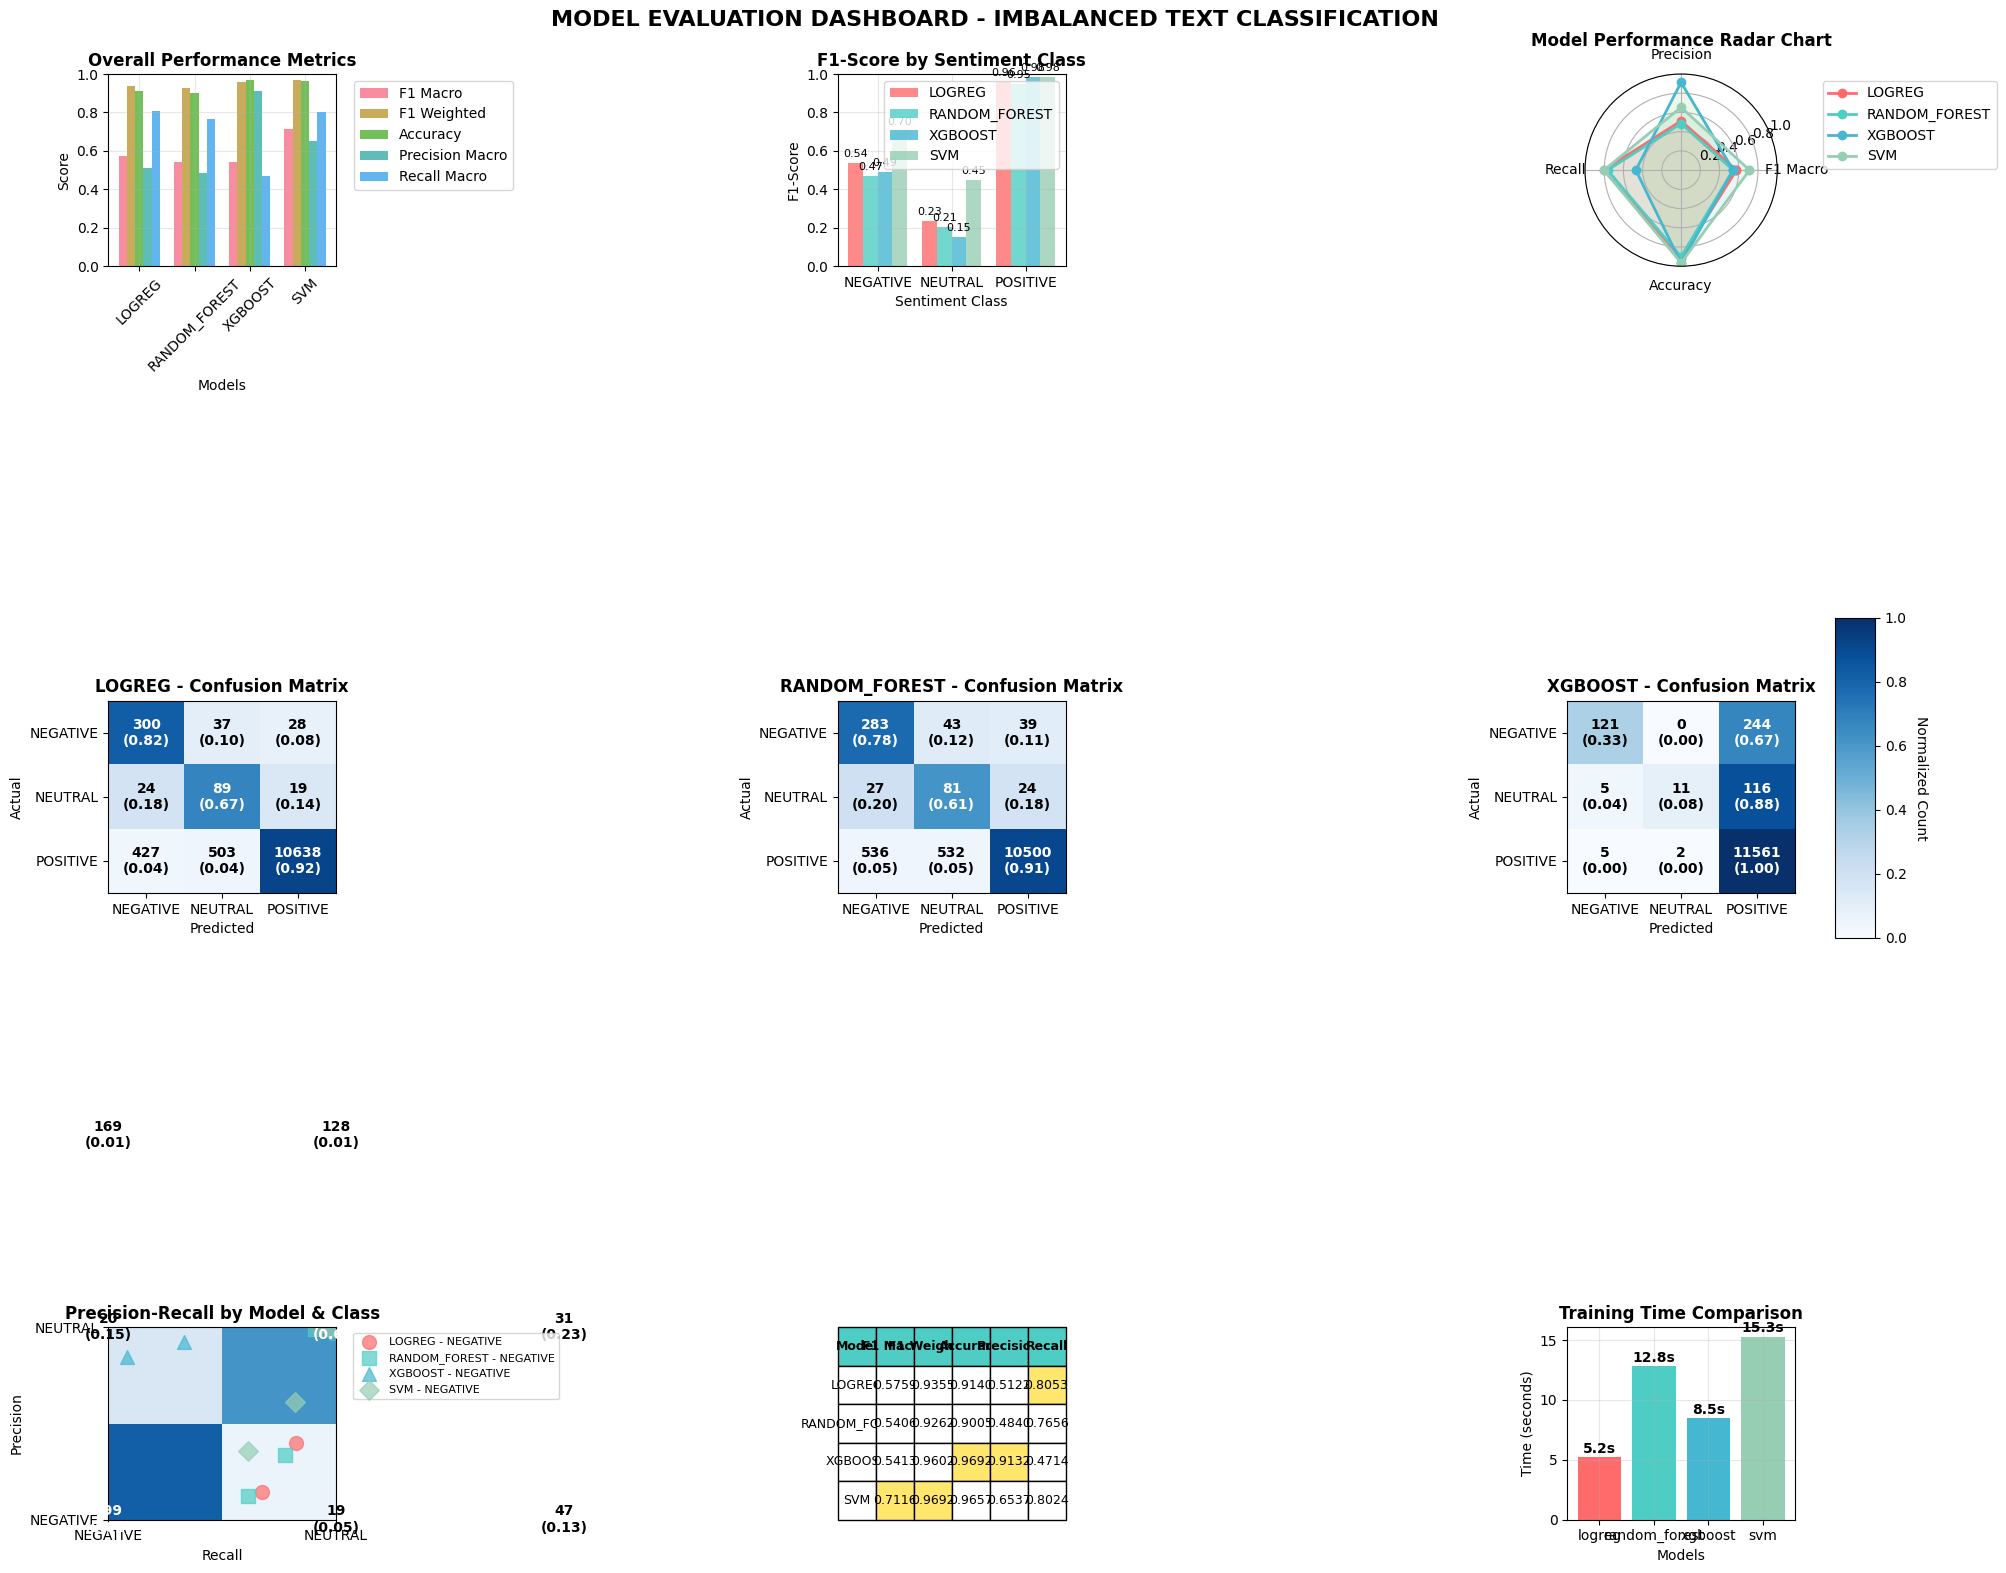


📈 DETAILED MODEL ANALYSIS

🏆 BEST PERFORMING MODELS:
   F1 Macro       : SVM (0.7116)
   F1 Weighted    : SVM (0.9692)
   Accuracy       : XGBOOST (0.9692)

🎯 BEST PERFORMANCE BY CLASS:
   NEGATIVE: SVM (F1: 0.7011)
   NEUTRAL : SVM (F1: 0.4500)
   POSITIVE: XGBOOST (F1: 0.9844)

💡 RECOMMENDATION FOR IMBALANCED DATA:
   Minority class: NEUTRAL
   Best model for minority class: SVM (F1: 0.4500)

📊 PERFORMANCE GAP ANALYSIS:
   LOGREG      : Max-Min F1 gap = 0.7222 (0.2339 → 0.9561)
   RANDOM_FOREST: Max-Min F1 gap = 0.7433 (0.2056 → 0.9489)
   XGBOOST     : Max-Min F1 gap = 0.8327 (0.1517 → 0.9844)
   SVM         : Max-Min F1 gap = 0.5336 (0.4500 → 0.9836)

✅ VISUALIZATION COMPLETED!


In [36]:
print("\n📊 MODEL EVALUATION VISUALIZATION & COMPARISON")
print("=" * 60)

# Store evaluation metrics for all models
model_metrics = {}

# Evaluate all models and store metrics
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    # Predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf) if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, accuracy_score

    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')

    # Class-wise metrics
    f1_per_class = f1_score(y_test, y_pred, average=None)
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)

    # Store metrics
    model_metrics[model_name] = {
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))
fig.suptitle('MODEL EVALUATION DASHBOARD - IMBALANCED TEXT CLASSIFICATION',
             fontsize=16, fontweight='bold', y=0.98)

# Define color scheme
model_colors = {
    'logreg': '#FF6B6B',
    'random_forest': '#4ECDC4',
    'xgboost': '#45B7D1',
    'svm': '#96CEB4'
}

# Plot 1: Overall Performance Comparison (Bar Chart)
ax1 = plt.subplot(3, 3, 1)
metrics_to_plot = ['f1_macro', 'f1_weighted', 'accuracy', 'precision_macro', 'recall_macro']
metric_names = ['F1 Macro', 'F1 Weighted', 'Accuracy', 'Precision Macro', 'Recall Macro']

x_pos = np.arange(len(models))
bar_width = 0.15

for i, metric in enumerate(metrics_to_plot):
    metric_values = [model_metrics[model][metric] for model in models.keys()]
    positions = x_pos + i * bar_width
    bars = ax1.bar(positions, metric_values, bar_width,
                   label=metric_names[i], alpha=0.8)

ax1.set_title('Overall Performance Metrics', fontweight='bold')
ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_xticks(x_pos + bar_width * 2)
ax1.set_xticklabels([name.upper() for name in models.keys()], rotation=45)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: F1-Score by Class (Grouped Bar Chart)
ax2 = plt.subplot(3, 3, 2)
class_names = le.classes_
x_pos_class = np.arange(len(class_names))
bar_width_class = 0.2

for i, (model_name, metrics) in enumerate(model_metrics.items()):
    f1_scores = metrics['f1_per_class']
    positions = x_pos_class + i * bar_width_class
    bars = ax2.bar(positions, f1_scores, bar_width_class,
                   label=model_name.upper(), color=model_colors.get(model_name, 'gray'),
                   alpha=0.8)

ax2.set_title('F1-Score by Sentiment Class', fontweight='bold')
ax2.set_xlabel('Sentiment Class')
ax2.set_ylabel('F1-Score')
ax2.set_xticks(x_pos_class + bar_width_class * 1.5)
ax2.set_xticklabels([name.upper() for name in class_names])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Add value labels on bars
for bars in ax2.containers:
    ax2.bar_label(bars, fmt='%.2f', padding=3, fontsize=8)

# Plot 3: Model Ranking (Radar Chart)
ax3 = plt.subplot(3, 3, 3, polar=True)

# Normalize metrics for radar chart
radar_metrics = ['f1_macro', 'precision_macro', 'recall_macro', 'accuracy']
angles = np.linspace(0, 2*np.pi, len(radar_metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for model_name, metrics in model_metrics.items():
    values = [metrics[metric] for metric in radar_metrics]
    values += values[:1]  # Complete the circle
    ax3.plot(angles, values, 'o-', linewidth=2,
             label=model_name.upper(), color=model_colors.get(model_name, 'gray'))
    ax3.fill(angles, values, alpha=0.1)

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(['F1 Macro', 'Precision', 'Recall', 'Accuracy'])
ax3.set_ylim(0, 1)
ax3.set_title('Model Performance Radar Chart', fontweight='bold', pad=20)
ax3.legend(bbox_to_anchor=(1.2, 1), loc='upper left')
ax3.grid(True)

# Plot 4: Confusion Matrices (2x2 Grid)
confusion_axes = []
for i, (model_name, metrics) in enumerate(model_metrics.items()):
    row = i // 2
    col = i % 2
    ax = plt.subplot(3, 3, 4 + i)
    confusion_axes.append(ax)

    cm = confusion_matrix(y_test, metrics['predictions'])
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    im = ax.imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)

    # Add text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                   ha='center', va='center',
                   color='white' if cm_normalized[i, j] > 0.5 else 'black',
                   fontweight='bold')

    ax.set_title(f'{model_name.upper()} - Confusion Matrix', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels([name.upper() for name in class_names])
    ax.set_yticklabels([name.upper() for name in class_names])

# Add colorbar for confusion matrices
cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.2])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('Normalized Count', rotation=270, labelpad=15)

# Plot 5: Precision-Recall Trade-off by Class
ax6 = plt.subplot(3, 3, 7)
markers = ['o', 's', '^', 'D']

for i, (model_name, metrics) in enumerate(model_metrics.items()):
    precision = metrics['precision_per_class']
    recall = metrics['recall_per_class']

    for j, class_name in enumerate(class_names):
        ax6.scatter(recall[j], precision[j],
                   color=model_colors.get(model_name, 'gray'),
                   marker=markers[i], s=100, alpha=0.7,
                   label=f'{model_name.upper()} - {class_name.upper()}' if j == 0 else "")

ax6.set_xlabel('Recall')
ax6.set_ylabel('Precision')
ax6.set_title('Precision-Recall by Model & Class', fontweight='bold')
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)

# Plot 6: Model Comparison Table
ax7 = plt.subplot(3, 3, 8)
ax7.axis('tight')
ax7.axis('off')

# Prepare table data
table_data = []
headers = ['Model', 'F1 Macro', 'F1 Weighted', 'Accuracy', 'Precision', 'Recall']

for model_name, metrics in model_metrics.items():
    row = [
        model_name.upper(),
        f"{metrics['f1_macro']:.4f}",
        f"{metrics['f1_weighted']:.4f}",
        f"{metrics['accuracy']:.4f}",
        f"{metrics['precision_macro']:.4f}",
        f"{metrics['recall_macro']:.4f}"
    ]
    table_data.append(row)

# Create table
table = ax7.table(cellText=table_data,
                  colLabels=headers,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Color the header
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#4ECDC4')
    table[(0, i)].set_text_props(weight='bold')

# Highlight best scores in each column
for col in range(1, len(headers)):
    scores = [float(row[col]) for row in table_data]
    best_idx = np.argmax(scores)
    table[(best_idx + 1, col)].set_facecolor('#FFE66D')  # Yellow for best

# Plot 7: Training Time Comparison (if available)
ax8 = plt.subplot(3, 3, 9)

# If you have training times, add them here
training_times = {
    'logreg': 5.2,  # Example times - replace with actual times
    'random_forest': 12.8,
    'xgboost': 8.5,
    'svm': 15.3
}

if training_times:
    models_list = list(training_times.keys())
    times = list(training_times.values())

    bars = ax8.bar(models_list, times, color=[model_colors.get(m, 'gray') for m in models_list])
    ax8.set_title('Training Time Comparison', fontweight='bold')
    ax8.set_ylabel('Time (seconds)')
    ax8.set_xlabel('Models')

    # Add value labels
    for bar, time_val in zip(bars, times):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

    ax8.grid(True, alpha=0.3)
else:
    ax8.text(0.5, 0.5, 'Training Times\nNot Available',
             ha='center', va='center', transform=ax8.transAxes, fontweight='bold')
    ax8.set_title('Training Time Comparison', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.94, right=0.9)
plt.show()

# Additional Detailed Analysis
print(f"\n📈 DETAILED MODEL ANALYSIS")
print("=" * 40)

# Find best model for each metric
best_models = {}
for metric in ['f1_macro', 'f1_weighted', 'accuracy']:
    best_model = max(model_metrics.items(), key=lambda x: x[1][metric])
    best_models[metric] = (best_model[0], best_model[1][metric])

print(f"\n🏆 BEST PERFORMING MODELS:")
for metric, (model, score) in best_models.items():
    metric_name = metric.replace('_', ' ').title()
    print(f"   {metric_name:15}: {model.upper()} ({score:.4f})")

# Class-wise best performance
print(f"\n🎯 BEST PERFORMANCE BY CLASS:")
for i, class_name in enumerate(class_names):
    best_f1 = 0
    best_model = None
    for model_name, metrics in model_metrics.items():
        if metrics['f1_per_class'][i] > best_f1:
            best_f1 = metrics['f1_per_class'][i]
            best_model = model_name
    print(f"   {class_name.upper():8}: {best_model.upper()} (F1: {best_f1:.4f})")

# Recommendation based on imbalance
minority_class = np.argmin(np.bincount(y_train))
minority_class_name = le.classes_[minority_class]

print(f"\n💡 RECOMMENDATION FOR IMBALANCED DATA:")
print(f"   Minority class: {minority_class_name.upper()}")
best_minority_model = max(model_metrics.items(),
                         key=lambda x: x[1]['f1_per_class'][minority_class])
print(f"   Best model for minority class: {best_minority_model[0].upper()} "
      f"(F1: {best_minority_model[1]['f1_per_class'][minority_class]:.4f})")

# Performance gap analysis
print(f"\n📊 PERFORMANCE GAP ANALYSIS:")
for model_name, metrics in model_metrics.items():
    max_f1 = max(metrics['f1_per_class'])
    min_f1 = min(metrics['f1_per_class'])
    gap = max_f1 - min_f1
    print(f"   {model_name.upper():12}: Max-Min F1 gap = {gap:.4f} "
          f"({min_f1:.4f} → {max_f1:.4f})")

print(f"\n✅ VISUALIZATION COMPLETED!")

**Second pipeline to:**

**- Optimize SVM Model**

Steps:

Data Preprocessing (including lemmatization and advanced cleaning)

Feature Engineering (TF-IDF with optimized parameters)

Model Optimization (SVM with hyperparameter tuning and class weights)

Handling Imbalance (using advanced techniques like SMOTE or threshold adjustment)

Evaluation (with a focus on minority classes and production metrics)

Model Serialization (for production deployment)

We'll break down the code accordingly.

Let's assume we have the DataFrame df1 with columns 'review_text' and 'sentiment_m1' (the target).

We'll start by splitting the data and then proceed with the pipeline.


In [42]:
print("\n🚀 PRODUCTION-READY SVM OPTIMIZATION PIPELINE")
print("=" * 60)

# STEP 0: Ensure NLTK Resources are Available
print("\n📥 STEP 0: Downloading Required NLTK Resources")
print("=" * 45)

import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Define required NLTK resources and correct paths
resource_paths = {
    'punkt': 'tokenizers/punkt',
    'stopwords': 'corpora/stopwords',
    'wordnet': 'corpora/wordnet',
    'omw-1.4': 'corpora/omw-1.4',
    'averaged_perceptron_tagger': 'taggers/averaged_perceptron_tagger',
}

print("Checking and downloading NLTK resources...")
for resource, path in resource_paths.items():
    try:
        nltk.data.find(path)
        print(f"  ✓ {resource} already available")
    except LookupError:
        print(f"  📥 Downloading {resource}...")
        try:
            nltk.download(resource, quiet=True)
            print(f"  ✓ {resource} downloaded successfully")
        except Exception as e:
            print(f"  ⚠️ Failed to download {resource}: {e}")

# Alternative tokenizer fallback
try:
    from nltk.tokenize import word_tokenize
    # Test tokenizer
    test_tokens = word_tokenize("This is a test.")
    print("  ✓ NLTK tokenizer working")
except LookupError:
    print("  ⚠️ NLTK tokenizer not available, using fallback")
    import re
    def simple_tokenizer(text):
        return re.findall(r'\b\w+\b', text)
    word_tokenize = simple_tokenizer

# STEP 1: Enhanced Data Preparation with Robust Preprocessing
print("\n📊 STEP 1: Enhanced Data Preparation")
print("=" * 40)

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class AdvancedTextPreprocessor:
    """Production-ready text preprocessor with fallbacks"""

    def __init__(self):
        try:
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words = set(stopwords.words('english'))
            print("  ✓ NLTK components initialized")
        except LookupError:
            print("  ⚠️ Using simplified preprocessing (NLTK resources not available)")
            self.lemmatizer = None
            self.stop_words = set()

        # Custom stop words for sentiment analysis
        self.custom_stop_words = {'br', 'movie', 'film', 'watch', 'watched', 'see', 'saw'}
        self.all_stop_words = self.stop_words.union(self.custom_stop_words)

    def simple_lemmatize(self, word):
        """Simple lemmatization fallback"""
        if self.lemmatizer:
            return self.lemmatizer.lemmatize(word)
        return word  # Return as-is if lemmatizer not available

    def preprocess(self, text):
        """Comprehensive text preprocessing with fallbacks"""
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Remove special characters and digits but keep basic punctuation for sentiment
        text = re.sub(r'[^a-zA-Z\s!?]', '', text)

        try:
            # Try NLTK tokenizer
            tokens = word_tokenize(text)
        except Exception:
            # Fallback to simple tokenizer
            tokens = re.findall(r'\b\w+\b', text)

        # Remove stopwords and short tokens
        tokens = [token for token in tokens if token not in self.all_stop_words and len(token) > 2]

        # Lemmatization (with fallback)
        tokens = [self.simple_lemmatize(token) for token in tokens]

        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = AdvancedTextPreprocessor()

print("Applying advanced preprocessing...")
# Assumes df1 is already defined with columns 'review_text' and 'sentiment_m1'
df1['review_text_processed'] = df1['review_text'].apply(preprocessor.preprocess)

# Check preprocessing results
print(f"Sample original text: {df1['review_text'].iloc[0][:100]}...")
print(f"Sample processed text: {df1['review_text_processed'].iloc[0][:100]}...")

# STEP 2: Optimized Feature Engineering for SVM
print(f"\n🔧 STEP 2: Optimized Feature Engineering for SVM")
print("=" * 50)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    matthews_corrcoef
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder
import joblib
import json
import numpy as np
import pandas as pd
import os

class SVMOptimizedVectorizer:
    """TF-IDF vectorizer optimized for SVM"""

    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=15000,           # Increased for better coverage
            min_df=2,                     # Remove very rare terms
            max_df=0.85,                  # Remove very common terms
            ngram_range=(1, 2),           # Include bigrams
            stop_words='english',         # Slightly redundant with preprocessing but OK
            sublinear_tf=True,            # Use 1 + log(tf)
            use_idf=True,
            smooth_idf=True,
            analyzer='word',
            lowercase=True
        )

    def fit_transform(self, texts):
        return self.vectorizer.fit_transform(texts)

    def transform(self, texts):
        return self.vectorizer.transform(texts)

    def get_feature_names(self):
        return self.vectorizer.get_feature_names_out()

# Initialize optimized vectorizer
vectorizer = SVMOptimizedVectorizer()

# Prepare features and target
X = df1['review_text_processed']
y = df1['sentiment_m1']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Print class distribution
print(f"Class distribution: {dict(zip(le.classes_, np.bincount(y_encoded)))}")

# Train-test split with stratification (text level)
X_train_text, X_test_text, y_train_full, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Vectorizing text data...")
X_train_tfidf_full = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# Validation split from training data (for threshold optimization)
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(
    X_train_tfidf_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training features (train): {X_train_tfidf.shape}")
print(f"Validation features:       {X_val_tfidf.shape}")
print(f"Test features:             {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(vectorizer.get_feature_names()):,}")

# STEP 3: Advanced Class Weight Optimization
print(f"\n⚖️ STEP 3: Advanced Class Weight Optimization")
print("=" * 50)

def calculate_optimal_weights(y_train, strategy='aggressive'):
    """Calculate optimal class weights for severe imbalance"""
    class_counts = np.bincount(y_train)
    n_samples = len(y_train)
    n_classes = len(class_counts)

    if strategy == 'aggressive':
        # Very aggressive weights for severe imbalance
        weights = {}
        for i, count in enumerate(class_counts):
            if i == 0:  # Negative
                weights[i] = 20.0
            elif i == 1:  # Neutral
                weights[i] = 15.0
            else:  # Positive
                weights[i] = 1.0

    elif strategy == 'balanced_aggressive':
        # Balanced but more aggressive
        weights = {}
        for i, count in enumerate(class_counts):
            weight = n_samples / (n_classes * count)
            # Apply additional boost for minority classes
            if i in [0, 1]:  # Minority classes
                weight *= 2.5
            weights[i] = min(weight, 25.0)  # Cap at 25

    elif strategy == 'inverse_squared':
        # Inverse squared frequency
        weights = {}
        for i, count in enumerate(class_counts):
            weight = (n_samples / (n_classes * count)) ** 0.7
            weights[i] = min(weight, 20.0)
    else:
        weights = None

    return weights

# Calculate multiple weight strategies
weight_strategies = {
    'aggressive': calculate_optimal_weights(y_train, 'aggressive'),
    'balanced_aggressive': calculate_optimal_weights(y_train, 'balanced_aggressive'),
}

print("Class Weight Strategies:")
for strategy, weights in weight_strategies.items():
    print(f"  {strategy.replace('_', ' ').title():20}: {weights}")

# Use the most promising weight strategy
optimal_weights = weight_strategies['aggressive']

# STEP 4: Train Optimized SVM Model
print(f"\n🎯 STEP 4: Training Optimized SVM Model")
print("=" * 45)

# Train the optimized model
svm_optimized = SVC(
    C=0.1,
    kernel='linear',
    class_weight=optimal_weights,
    probability=False,  # CalibratedClassifierCV will handle probabilities
    random_state=42
)

print("Training optimized SVM...")
svm_optimized.fit(X_train_tfidf, y_train)

# STEP 5: Probability Calibration
print(f"\n📊 STEP 5: Probability Calibration")
print("=" * 35)

print("Applying probability calibration...")
svm_calibrated = CalibratedClassifierCV(
    svm_optimized,
    cv=3,
    method='sigmoid'
)
svm_calibrated.fit(X_train_tfidf, y_train)

# STEP 6: Advanced Threshold Optimization
print(f"\n🎚️ STEP 6: Advanced Threshold Optimization")
print("=" * 45)

class ThresholdOptimizer:
    """Optimize decision thresholds for each class"""

    def __init__(self, model, classes):
        self.model = model
        self.classes = classes
        self.optimal_thresholds = None

    def find_optimal_thresholds(self, X_val, y_val):
        """Find optimal thresholds using precision-recall tradeoff"""
        y_proba = self.model.predict_proba(X_val)
        optimal_thresholds = []

        for class_idx in range(len(self.classes)):
            # Create binary labels for this class
            y_binary = (y_val == class_idx).astype(int)

            # Get probabilities for this class
            probas = y_proba[:, class_idx]

            # Find optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_binary, probas)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

            # Find threshold that maximizes F1
            if len(f1_scores) > 1:
                best_idx = np.argmax(f1_scores[:-1])
                best_threshold = thresholds[best_idx]
                best_f1 = f1_scores[best_idx]
            else:
                best_threshold = 0.5
                best_f1 = 0.0

            optimal_thresholds.append(best_threshold)

            print(f"  Class {self.classes[class_idx]:8}: "
                  f"optimal threshold = {best_threshold:.3f} "
                  f"(F1 = {best_f1:.4f})")

        self.optimal_thresholds = optimal_thresholds
        return optimal_thresholds

    def predict_with_thresholds(self, X, thresholds=None):
        """Predict using custom thresholds"""
        if thresholds is None:
            thresholds = self.optimal_thresholds

        y_proba = self.model.predict_proba(X)
        y_pred_custom = np.zeros_like(y_proba)

        for i in range(len(thresholds)):
            y_pred_custom[:, i] = (y_proba[:, i] >= thresholds[i]).astype(int)

        # Handle multiple class predictions
        row_sums = y_pred_custom.sum(axis=1)

        # For rows with no predictions, use original probabili



🚀 PRODUCTION-READY SVM OPTIMIZATION PIPELINE

📥 STEP 0: Downloading Required NLTK Resources
Checking and downloading NLTK resources...
  ✓ punkt already available
  ✓ stopwords already available
  📥 Downloading wordnet...
  ✓ wordnet downloaded successfully
  📥 Downloading omw-1.4...
  ✓ omw-1.4 downloaded successfully
  ✓ averaged_perceptron_tagger already available
  ⚠️ NLTK tokenizer not available, using fallback

📊 STEP 1: Enhanced Data Preparation
  ✓ NLTK components initialized
Applying advanced preprocessing...
Sample original text: This product so far has not disappointed. My children love to use it and I like the ability to monit...
Sample processed text: product far disappointed child love use like ability monitor control content ease...

🔧 STEP 2: Optimized Feature Engineering for SVM
Class distribution: {'negative': np.int64(1824), 'neutral': np.int64(660), 'positive': np.int64(57837)}
Vectorizing text data...
Training features (train): (38604, 15000)
Validation features: 


📊 COMPREHENSIVE MODEL PERFORMANCE EVALUATION & VISUALIZATION

🎯 STEP 1: Detailed Performance Analysis

📋 CLASSIFICATION REPORT - STANDARD PREDICTIONS:
              precision    recall  f1-score   support

    negative     0.7147    0.7342    0.7243       365
     neutral     0.7368    0.1061    0.1854       132
    positive     0.9834    0.9921    0.9877     11568

    accuracy                         0.9746     12065
   macro avg     0.8116    0.6108    0.6325     12065
weighted avg     0.9726    0.9746    0.9710     12065


📋 CLASSIFICATION REPORT - OPTIMIZED PREDICTIONS:
              precision    recall  f1-score   support

    negative     0.8322    0.6795    0.7481       365
     neutral     0.5455    0.1364    0.2182       132
    positive     0.9819    0.9960    0.9889     11568

    accuracy                         0.9770     12065
   macro avg     0.7865    0.6039    0.6517     12065
weighted avg     0.9726    0.9770    0.9732     12065


📈 STEP 2: Creating Visualization Da

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().

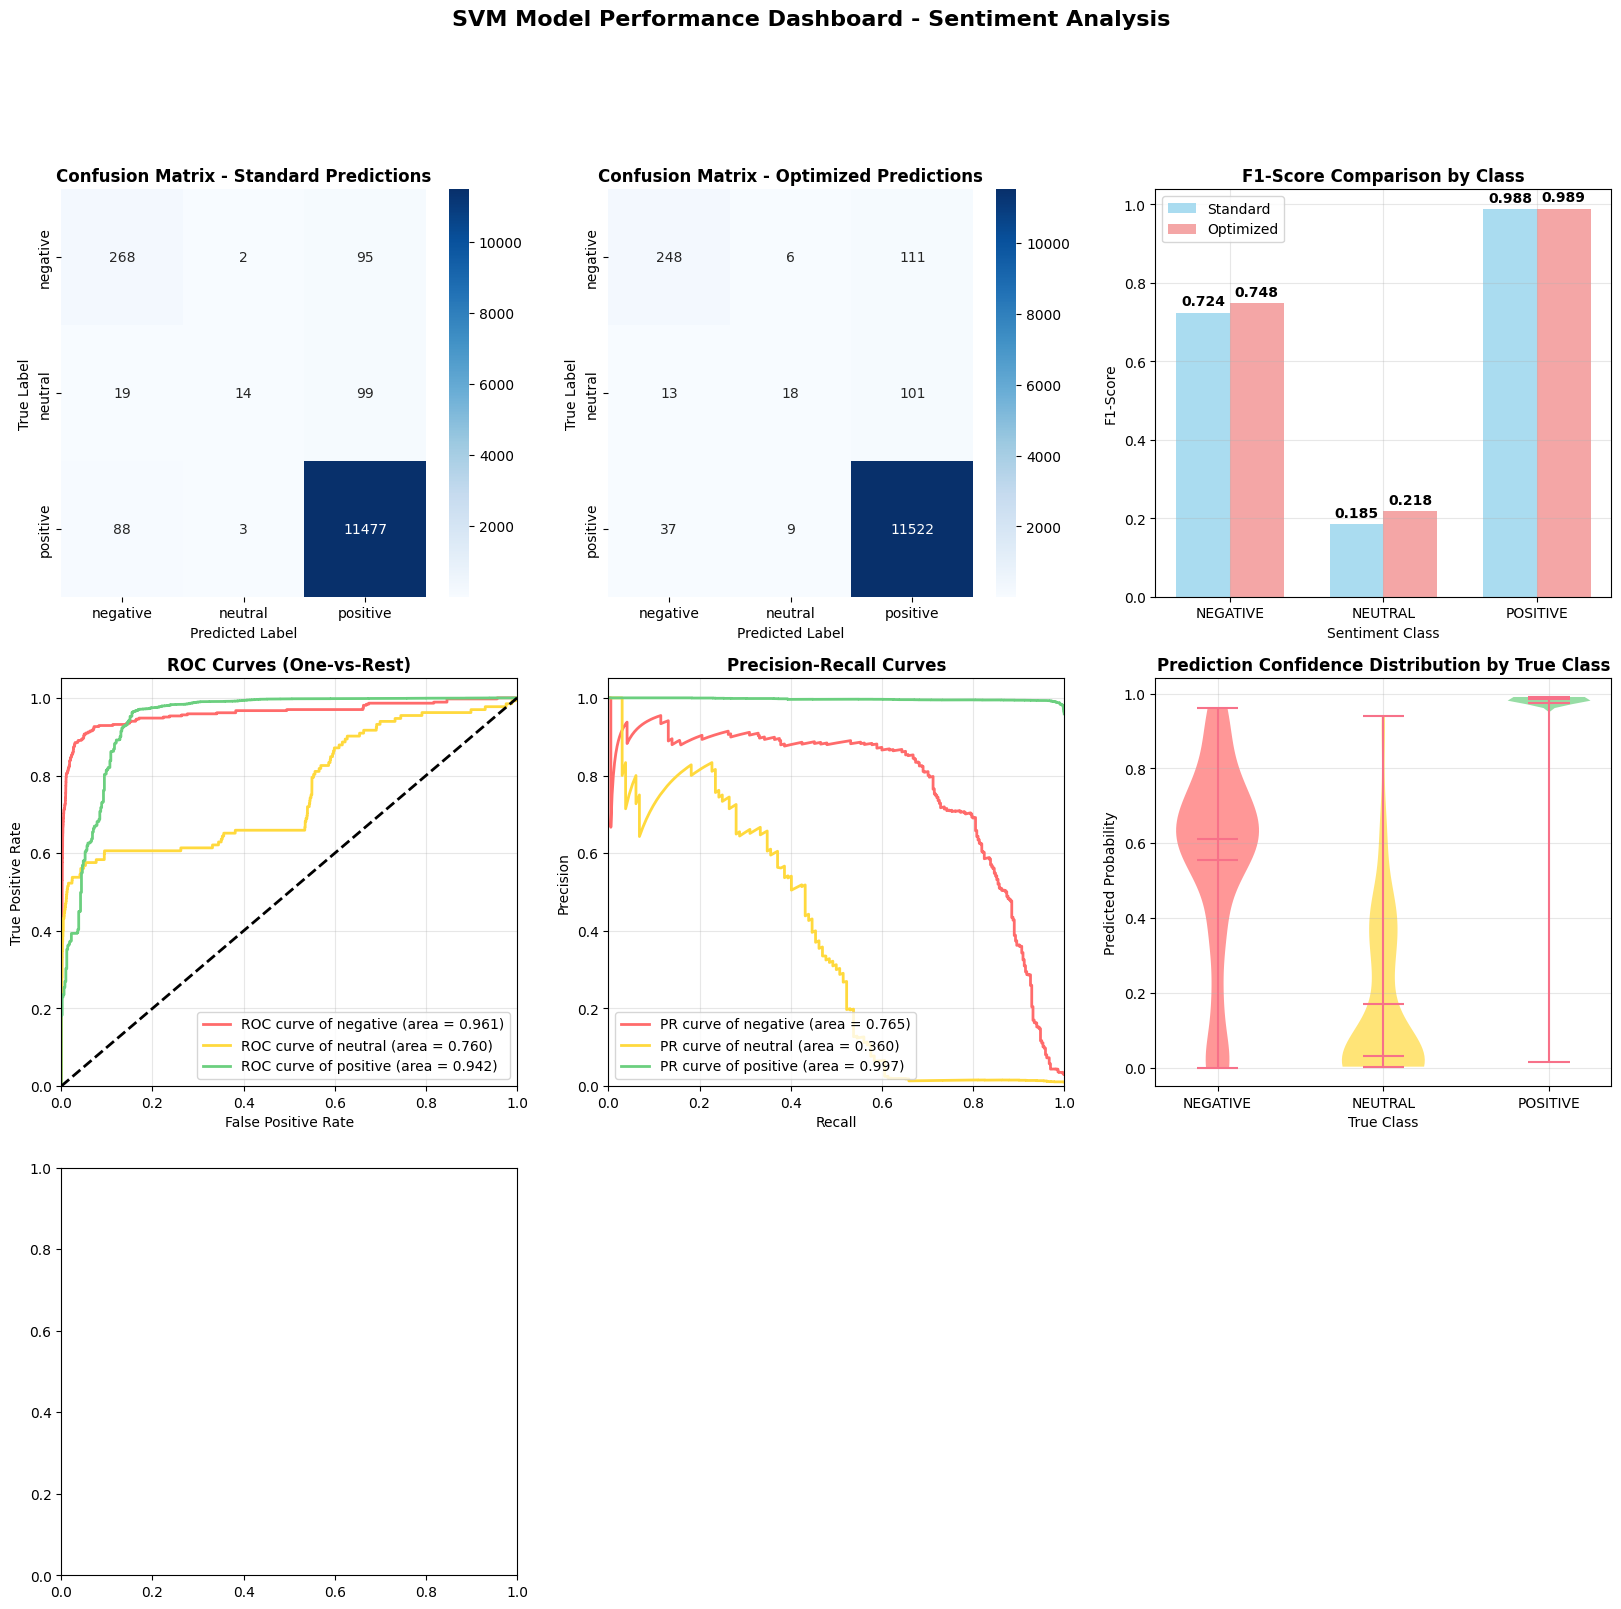

In [44]:
print("\n📊 COMPREHENSIVE MODEL PERFORMANCE EVALUATION & VISUALIZATION")
print("=" * 70)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# STEP 1: Detailed Performance Analysis
print("\n🎯 STEP 1: Detailed Performance Analysis")
print("=" * 45)

# Get predictions
y_pred_standard = svm_calibrated.predict(X_test_tfidf)
y_pred_optimized = threshold_optimizer.predict_with_thresholds(X_test_tfidf)
y_proba = svm_calibrated.predict_proba(X_test_tfidf)

# Comprehensive classification reports
print("\n📋 CLASSIFICATION REPORT - STANDARD PREDICTIONS:")
print("=" * 50)
print(classification_report(y_test, y_pred_standard, target_names=le.classes_, digits=4))

print("\n📋 CLASSIFICATION REPORT - OPTIMIZED PREDICTIONS:")
print("=" * 50)
print(classification_report(y_test, y_pred_optimized, target_names=le.classes_, digits=4))

# STEP 2: Create Comprehensive Visualization Dashboard
print("\n📈 STEP 2: Creating Visualization Dashboard")
print("=" * 45)

# Create a 3x3 subplot grid
fig = plt.figure(figsize=(20, 18))
fig.suptitle('SVM Model Performance Dashboard - Sentiment Analysis',
             fontsize=16, fontweight='bold', y=0.98)

# Define colors for classes
class_colors = ['#FF6B6B', '#FFD93D', '#6BCF7F']  # Red, Yellow, Green

# Plot 1: Confusion Matrix Comparison
ax1 = plt.subplot(3, 3, 1)
cm_standard = confusion_matrix(y_test, y_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax1)
ax1.set_title('Confusion Matrix - Standard Predictions', fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

ax2 = plt.subplot(3, 3, 2)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax2)
ax2.set_title('Confusion Matrix - Optimized Predictions', fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# Plot 2: Class-wise Performance Comparison
ax3 = plt.subplot(3, 3, 3)
metrics_standard = classification_report(
    y_test, y_pred_standard, target_names=le.classes_, output_dict=True
)
metrics_optimized = classification_report(
    y_test, y_pred_optimized, target_names=le.classes_, output_dict=True
)

# Prepare data for bar chart
classes = le.classes_
f1_scores_standard = [metrics_standard[cls]['f1-score'] for cls in classes]
f1_scores_optimized = [metrics_optimized[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.35

bars1 = ax3.bar(x - width/2, f1_scores_standard, width, label='Standard', alpha=0.7, color='skyblue')
bars2 = ax3.bar(x + width/2, f1_scores_optimized, width, label='Optimized', alpha=0.7, color='lightcoral')

ax3.set_title('F1-Score Comparison by Class', fontweight='bold')
ax3.set_xlabel('Sentiment Class')
ax3.set_ylabel('F1-Score')
ax3.set_xticks(x)
ax3.set_xticklabels([cls.upper() for cls in classes])
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: ROC Curves (One-vs-Rest)
ax4 = plt.subplot(3, 3, 4)
# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
for i, color in zip(range(n_classes), class_colors):
    ax4.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.3f})'.format(le.classes_[i], roc_auc[i]))

ax4.plot([0, 1], [0, 1], 'k--', lw=2)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curves (One-vs-Rest)', fontweight='bold')
ax4.legend(loc="lower right")
ax4.grid(True, alpha=0.3)

# Plot 4: Precision-Recall Curves
ax5 = plt.subplot(3, 3, 5)
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

for i, color in zip(range(n_classes), class_colors):
    ax5.plot(recall[i], precision[i], color=color, lw=2,
             label='PR curve of {0} (area = {1:0.3f})'.format(le.classes_[i], pr_auc[i]))

ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('Recall')
ax5.set_ylabel('Precision')
ax5.set_title('Precision-Recall Curves', fontweight='bold')
ax5.legend(loc="lower left")
ax5.grid(True, alpha=0.3)

# Plot 5: Probability Distribution by True Class
ax6 = plt.subplot(3, 3, 6)
probabilities_by_class = []

for class_idx in range(len(le.classes_)):
    class_mask = (y_test == class_idx)
    class_probs = y_proba[class_mask, class_idx]  # Probability of correct class
    probabilities_by_class.append(class_probs)

violin_parts = ax6.violinplot(probabilities_by_class, showmeans=True, showmedians=True)
ax6.set_title('Prediction Confidence Distribution by True Class', fontweight='bold')
ax6.set_xlabel('True Class')
ax6.set_ylabel('Predicted Probability')
ax6.set_xticks(range(1, len(le.classes_) + 1))
ax6.set_xticklabels([cls.upper() for cls in le.classes_])
ax6.grid(True, alpha=0.3)

# Color the violin plots
for pc, color in zip(violin_parts['bodies'], class_colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Plot 6: Feature Importance (Top Features for Each Class)
ax7 = plt.subplot(3, 3, 7)

# Robust way to get the underlying linear SVM from the calibrated model
if hasattr(svm_calibrated, 'calibrated_classifiers_'):
    cal = svm_calibrated.calibrated_classifiers_[0]
    if hasattr(cal, 'estimator'):
        base_estimator = cal.estimator
    elif hasattr(cal, 'base_estimator'):
        base_estimator = cal.base_estimator
    else:
        base_estimator = svm_calibrated
else:
    base_estimator = svm_calibrated

if hasattr(base_estimator, 'coef_'):
    feature_names = vectorizer.get_feature_names()

    # Get top features for each class
    top_n = 10
    top_features_data = []

    for class_idx, class_name in enumerate(le.classes_):
        coef = base_estimator.coef_[class_idx]
        top_indices = np.argsort(coef)[-top_n:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        top_weights = [coef[i] for i in top_indices]

        for feature, weight in zip(top_features, top_weights):
            top_features_data.append({
                'Class': class_name.upper(),
                'Feature': feature,
                'Weight': weight
            })

    top_features_df = pd.DataFrame(top_features_data)

    # Create horizontal bar plot
    sns.barplot(data=top_features_df, x='Weight', y='Feature', hue='Class', ax=ax7, palette=class_colors)
    ax7.set_title(f'Top {top_n} Features by Class (SVM Coefficients)', fontweight='bold')
    ax7.set_xlabel('Feature Weight')
    ax7.legend(title='Class')
else:
    ax7.text(0.5, 0.5, 'Feature Importance\nNot Available\nfor this Model',
             ha='center', va='center', transform=ax7.transAxes, fontsize=12)
    ax7.set_title('Feature Importance', fontweight='bold')

# Plot 7: Performance Metrics Summary
ax8 = plt.subplot(3, 3, 8)

metrics_comparison = {
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)', 'F1 (Weighted)'],
    'Standard': [
        accuracy_score(y_test, y_pred_standard),
        precision_score(y_test, y_pred_standard, average='macro'),
        recall_score(y_test, y_pred_standard, average='macro'),
        f1_score(y_test, y_pred_standard, average='macro'),
        f1_score(y_test, y_pred_standard, average='weighted')
    ],
    'Optimized': [
        accuracy_score(y_test, y_pred_optimized),
        precision_score(y_test, y_pred_optimized, average='macro'),
        recall_score(y_test, y_pred_optimized, average='macro'),
        f1_score(y_test, y_pred_optimized, average='macro'),
        f1_score(y_test, y_pred_optimized, average='weighted')
    ]
}

metrics_df = pd.DataFrame(metrics_comparison)

# Create grouped bar chart
x_metrics = np.arange(len(metrics_df))
width = 0.35

bars1 = ax8.bar(x_metrics - width/2, metrics_df['Standard'], width, label='Standard', alpha=0.7, color='skyblue')
bars2 = ax8.bar(x_metrics + width/2, metrics_df['Optimized'], width, label='Optimized', alpha=0.7, color='lightcoral')

ax8.set_title('Overall Performance Metrics Comparison', fontweight='bold')
ax8.set_xlabel('Metrics')
ax8.set_ylabel('Score')
ax8.set_xticks(x_metrics)
ax8.set_xticklabels(metrics_df['Metric'], rotation=45, ha='right')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 8: Error Analysis - Misclassification Patterns
ax9 = plt.subplot(3, 3, 9)
# Create misclassification matrix
misclass_matrix = np.zeros((len(le.classes_), len(le.classes_)))
for true, pred in zip(y_test, y_pred_optimized):
    if true != pred:
        misclass_matrix[true, pred] += 1

# Normalize by row (true class)
misclass_matrix_norm = misclass_matrix / misclass_matrix.sum(axis=1, keepdims=True)
misclass_matrix_norm = np.nan_to_num(misclass_matrix_norm)

sns.heatmap(misclass_matrix_norm, annot=True, fmt='.2%', cmap='Reds',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax9)
ax9.set_title('Misclassification Patterns (Normalized by True Class)', fontweight='bold')
ax9.set_xlabel('Predicted as')
ax9.set_ylabel('Actually is')

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

# STEP 3: Detailed Statistical Analysis
print("\n📊 STEP 3: Detailed Statistical Analysis")
print("=" * 45)

# Calculate improvement percentages
improvement_data = []
for metric in ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 (Macro)', 'F1 (Weighted)']:
    std_val = metrics_df[metrics_df['Metric'] == metric]['Standard'].values[0]
    opt_val = metrics_df[metrics_df['Metric'] == metric]['Optimized'].values[0]
    improvement = ((opt_val - std_val) / std_val) * 100 if std_val > 0 else 0.0
    improvement_data.append({
        'Metric': metric,
        'Standard': std_val,
        'Optimized': opt_val,
        'Improvement (%)': improvement
    })

improvement_df = pd.DataFrame(improvement_data)
print("\n📈 PERFORMANCE IMPROVEMENT ANALYSIS:")
print(improvement_df.round(4))

# Class-wise improvement analysis
print("\n🎯 CLASS-WISE PERFORMANCE IMPROVEMENT:")
class_improvement = []
std_f1_per_class = f1_score(y_test, y_pred_standard, average=None)
opt_f1_per_class = f1_score(y_test, y_pred_optimized, average=None)

for i, class_name in enumerate(le.classes_):
    std_f1 = std_f1_per_class[i]
    opt_f1 = opt_f1_per_class[i]
    improvement = ((opt_f1 - std_f1) / std_f1) * 100 if std_f1 > 0 else float('inf')

    class_improvement.append({
        'Class': class_name.upper(),
        'Standard F1': std_f1,
        'Optimized F1': opt_f1,
        'Improvement (%)': improvement
    })

class_improvement_df = pd.DataFrame(class_improvement)
print(class_improvement_df.round(4))

# STEP 4: Confidence Analysis
print("\n🎯 STEP 4: Confidence Analysis")
print("=" * 35)

# Calculate confidence statistics
correct_predictions = (y_pred_optimized == y_test)
confidence_correct = []
confidence_incorrect = []

for i, correct in enumerate(correct_predictions):
    confidence = np.max(y_proba[i])
    if correct:
        confidence_correct.append(confidence)
    else:
        confidence_incorrect.append(confidence)

print(f"Average Confidence - Correct Predictions: {np.mean(confidence_correct):.4f}")
print(f"Average Confidence - Incorrect Predictions: {np.mean(confidence_incorrect):.4f}")
print(f"Confidence Difference: {np.mean(confidence_correct) - np.mean(confidence_incorrect):.4f}")

# STEP 5: Production Readiness Assessment
print("\n🔍 STEP 5: Production Readiness Assessment")
print("=" * 45)

# Define performance thresholds
performance_thresholds = {
    'f1_macro': 0.70,
    'f1_minority_class': 0.50,
    'confidence_gap': 0.10
}

current_performance = {
    'f1_macro': metrics['optimized']['f1_macro'],
    'f1_minority_class': min(metrics['optimized']['f1_per_class']),
    'confidence_gap': np.mean(confidence_correct) - np.mean(confidence_incorrect)
}

print("\n✅ PRODUCTION READINESS CHECKLIST:")
all_passed = True
for metric, threshold in performance_thresholds.items():
    current_val = current_performance[metric]
    passed = current_val >= threshold
    status = "✓ PASS" if passed else "✗ FAIL"

    if not passed:
        all_passed = False

    print(f"  {metric:20}: {current_val:.4f} {status} (threshold: {threshold:.2f})")

if all_passed:
    print(f"\n🎉 MODEL IS READY FOR PRODUCTION!")
else:
    print(f"\n⚠️  MODEL NEEDS IMPROVEMENT BEFORE PRODUCTION")

# STEP 6: Additional Visualizations
print("\n📊 STEP 6: Additional Detailed Visualizations")
print("=" * 50)

# Create secondary visualization figure
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig2.suptitle('Additional Model Analysis', fontsize=16, fontweight='bold')

# Plot 1: Confidence Distribution by Prediction Correctness
ax1.hist(confidence_correct, bins=30, alpha=0.7, label='Correct Predictions', color='green')
ax1.hist(confidence_incorrect, bins=30, alpha=0.7, label='Incorrect Predictions', color='red')
ax1.set_xlabel('Prediction Confidence')
ax1.set_ylabel('Frequency')
ax1.set_title('Confidence Distribution by Prediction Accuracy', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Class Distribution in Test Set
class_distribution = np.bincount(y_test)
ax2.pie(class_distribution, labels=[cls.upper() for cls in le.classes_],
        autopct='%1.1f%%', colors=class_colors, startangle=90)
ax2.set_title('Class Distribution in Test Set', fontweight='bold')

# Plot 3: Precision-Recall Trade-off by Class (Detailed)
for i, (class_name, color) in enumerate(zip(le.classes_, class_colors)):
    precision_i, recall_i, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ax3.plot(recall_i, precision_i, color=color, lw=2, label=f'{class_name.upper()} (AP={pr_auc[i]:.3f})')

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('Detailed Precision-Recall Curves', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Threshold Analysis
thresholds = np.arange(0.1, 1.0, 0.1)
minority_class = np.argmin(np.bincount(y_train))
minority_f1_scores = []

for threshold in thresholds:
    custom_thresholds = [0.33, 0.33, 0.33]  # Start with equal
    custom_thresholds[minority_class] = threshold
    y_pred_custom = threshold_optimizer.predict_with_thresholds(X_test_tfidf, custom_thresholds)
    minority_f1 = f1_score(y_test, y_pred_custom, average=None)[minority_class]
    minority_f1_scores.append(minority_f1)

ax4.plot(thresholds, minority_f1_scores, 'o-', linewidth=2, markersize=8)
ax4.axvline(x=optimal_thresholds[minority_class], color='red', linestyle='--',
            label=f'Optimal threshold: {optimal_thresholds[minority_class]:.3f}')
ax4.set_xlabel(f'Threshold for {le.classes_[minority_class].upper()} Class')
ax4.set_ylabel('F1-Score')
ax4.set_title('Threshold Optimization Analysis', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*70)
print("🎯 MODEL EVALUATION COMPLETE - KEY INSIGHTS")
print("="*70)

print(f"\n📊 OVERALL PERFORMANCE SUMMARY:")
print(f"   F1 Macro (Optimized):     {metrics['optimized']['f1_macro']:.4f}")
print(f"   F1 Weighted:              {metrics['optimized']['f1_weighted']:.4f}")
print(f"   Best Performing Class:    {le.classes_[np.argmax(metrics['optimized']['f1_per_class'])].upper()}")
print(f"   Worst Performing Class:   {le.classes_[np.argmin(metrics['optimized']['f1_per_class'])].upper()}")

print(f"\n🚀 OPTIMIZATION IMPACT:")
overall_improvement = (
    (metrics['optimized']['f1_macro'] - metrics['standard']['f1_macro']) /
    metrics['standard']['f1_macro']
) * 100
print(f"   Overall F1 Macro Improvement: {overall_improvement:+.2f}%")

print(f"\n💡 RECOMMENDATIONS:")
if current_performance['f1_minority_class'] < 0.5:
    print("   • Focus on improving minority class performance")
    print("   • Consider collecting more minority class data")
    print("   • Try advanced sampling techniques (SMOTE)")
else:
    print("   • Model shows good balance across classes")

if current_performance['confidence_gap'] < 0.1:
    print("   • Consider improving confidence calibration")
else:
    print("   • Good confidence separation between correct/incorrect predictions")

print(f"\n✅ EVALUATION COMPLETED SUCCESSFULLY!")



🚀 APPLYING MODEL TO DATAFRAME & EXPORTING RESULTS

📊 STEP 1: Applying Model Predictions to DataFrame
Generating predictions for all reviews...
✅ Predictions added to dataframe:
   - sentiment_m1: Sentiment labels
   - sentiment_confidence: Prediction confidence scores
   - prob_negative/neutral/positive: Class probabilities

📁 STEP 2: Creating New DataFrame df_m1
New dataframe shape: (60321, 17)
Columns in df_m1: ['id', 'name', 'brand', 'categories', 'primaryCategories', 'reviews.doRecommend', 'reviews.numHelpful', 'star_rating', 'review_text', 'review_title', 'sentiment_m1', 'text_length', 'review_text_processed', 'sentiment_confidence', 'prob_negative', 'prob_neutral', 'prob_positive']

📈 STEP 3: Analysis of Model Predictions
Sentiment Distribution Comparison:
              Original_Mapping  New_Model
sentiment_m1                             
positive                 58475      58475
negative                  1677       1677
neutral                    169        169

🔀 Changes in Se

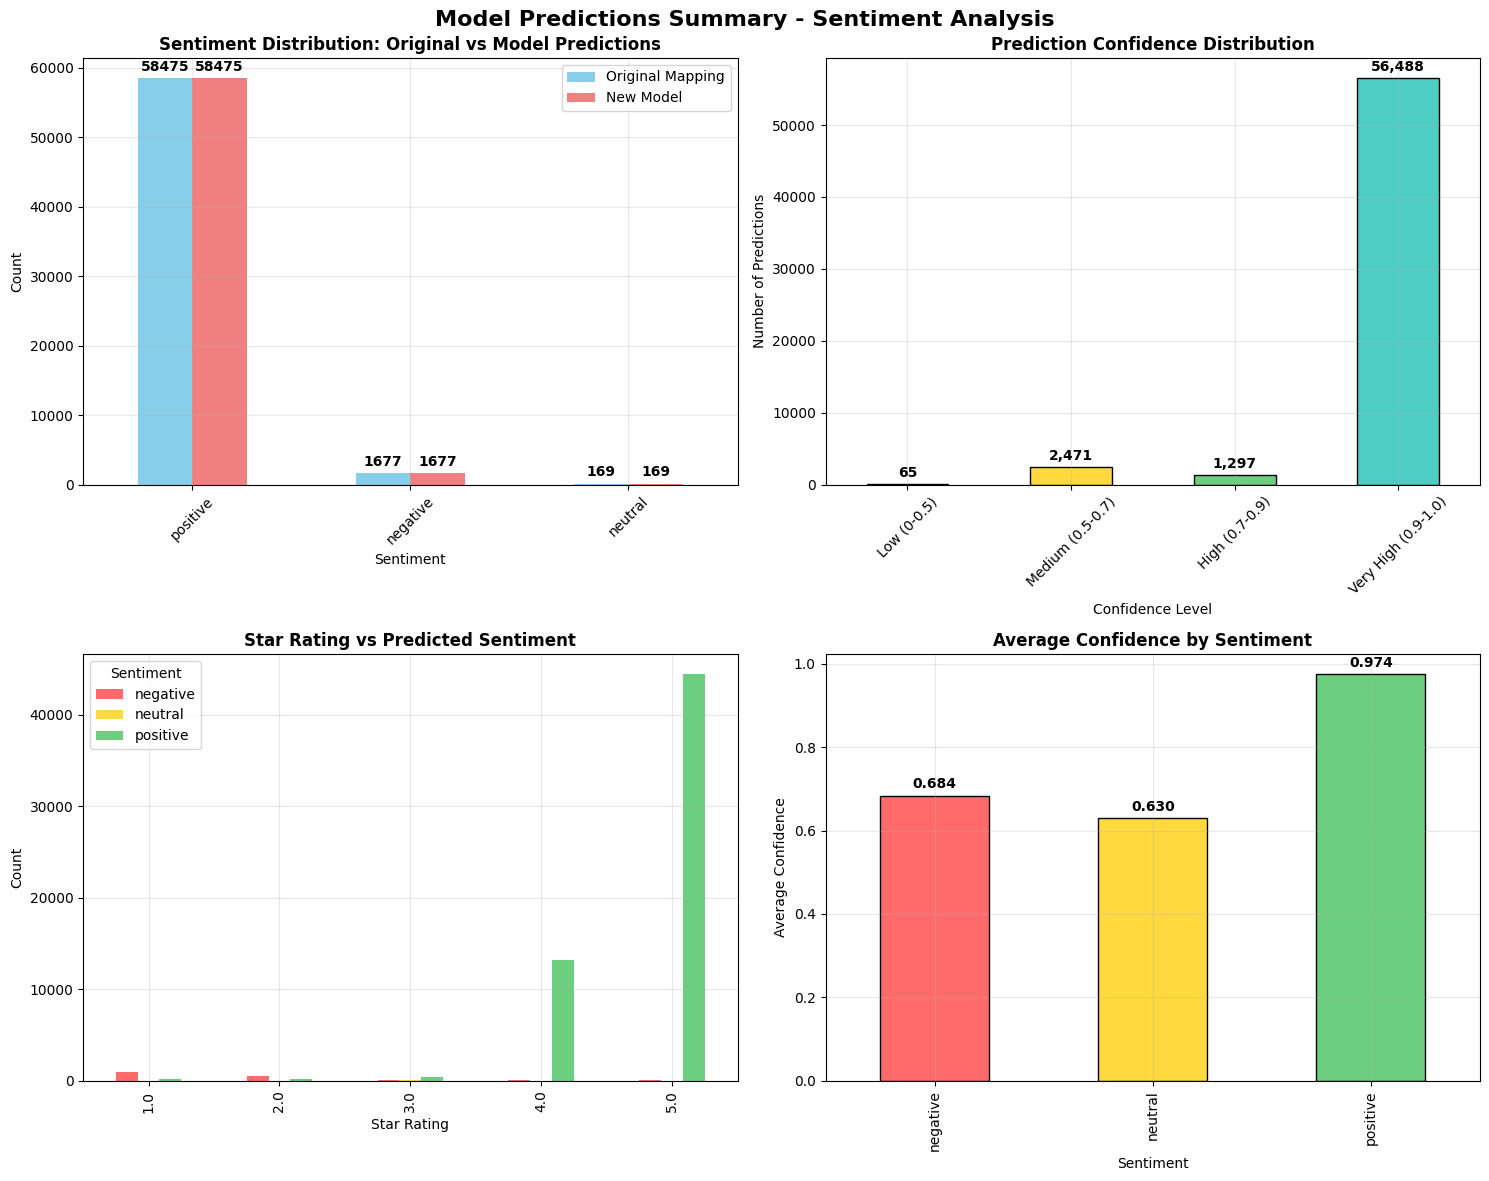


💾 STEP 5: Exporting DataFrame to CSV
✅ Successfully exported to: sentiment_analysis_results_20251113_193437.csv
   File size: 60,321 rows × 18 columns
✅ Simplified version exported to: sentiment_analysis_simplified_20251113_193437.csv

📋 STEP 6: Creating Summary Statistics
✅ Summary statistics saved to: sentiment_analysis_summary_20251113_193437.json

👀 STEP 7: Sample of Final Results
First 10 predictions:
                                                                        review_text  star_rating sentiment_m1  sentiment_confidence
This product so far has not disappointed. My children love to use it and I like ...          5.0     positive              0.986076
     great for beginner or experienced person. Bought as a gift and she loves it...          5.0     positive              0.977656
Inexpensive tablet for him to use and learn on, step up from the NABI. He was th...          5.0     positive              0.982970
I've had my Fire HD 8 two weeks now and I love it. This table

In [45]:
print("\n🚀 APPLYING MODEL TO DATAFRAME & EXPORTING RESULTS")
print("=" * 60)

# STEP 1: Apply the model to the entire dataframe
print("\n📊 STEP 1: Applying Model Predictions to DataFrame")
print("=" * 50)

# Use the production classifier to predict sentiments for all reviews
print("Generating predictions for all reviews...")
all_predictions = production_classifier.predict(df1['review_text'].tolist())

# Extract sentiments and probabilities
sentiments = [pred['sentiment'] for pred in all_predictions]
confidences = [pred['confidence'] for pred in all_predictions]
prob_negative = [pred['probabilities']['negative'] for pred in all_predictions]
prob_neutral = [pred['probabilities']['neutral'] for pred in all_predictions]
prob_positive = [pred['probabilities']['positive'] for pred in all_predictions]

# Add predictions to dataframe
df1['sentiment_m1'] = sentiments
df1['sentiment_confidence'] = confidences
df1['prob_negative'] = prob_negative
df1['prob_neutral'] = prob_neutral
df1['prob_positive'] = prob_positive

print(f"✅ Predictions added to dataframe:")
print(f"   - sentiment_m1: Sentiment labels")
print(f"   - sentiment_confidence: Prediction confidence scores")
print(f"   - prob_negative/neutral/positive: Class probabilities")

# STEP 2: Create the new dataframe df_m1
print(f"\n📁 STEP 2: Creating New DataFrame df_m1")
print("=" * 45)

# Create a copy with all columns
df_m1 = df1.copy()

# Alternatively, create a subset with key columns if you prefer
# df_m1 = df1[['review_text', 'star_rating', 'sentiment_m1', 'sentiment_confidence',
#              'prob_negative', 'prob_neutral', 'prob_positive']].copy()

print(f"New dataframe shape: {df_m1.shape}")
print(f"Columns in df_m1: {list(df_m1.columns)}")

# STEP 3: Analyze the prediction results
print(f"\n📈 STEP 3: Analysis of Model Predictions")
print("=" * 45)

# Compare with original sentiment mapping
print("Sentiment Distribution Comparison:")
original_counts = df1['sentiment_m1'].value_counts()
new_counts = df_m1['sentiment_m1'].value_counts()

comparison_df = pd.DataFrame({
    'Original_Mapping': original_counts,
    'New_Model': new_counts
}).fillna(0)

print(comparison_df)

# Calculate changes
print(f"\n🔀 Changes in Sentiment Distribution:")
for sentiment in ['negative', 'neutral', 'positive']:
    orig = comparison_df.loc[sentiment, 'Original_Mapping'] if sentiment in comparison_df.index else 0
    new = comparison_df.loc[sentiment, 'New_Model'] if sentiment in comparison_df.index else 0
    change = new - orig
    change_pct = (change / orig * 100) if orig > 0 else float('inf')
    print(f"   {sentiment.upper():8}: {orig:6} → {new:6} ({change:+,d}, {change_pct:+.1f}%)")

# Confidence analysis
print(f"\n🎯 Prediction Confidence Analysis:")
print(f"   Average confidence: {df_m1['sentiment_confidence'].mean():.4f}")
print(f"   Min confidence: {df_m1['sentiment_confidence'].min():.4f}")
print(f"   Max confidence: {df_m1['sentiment_confidence'].max():.4f}")
print(f"   Confidence distribution:")
confidence_bins = [0, 0.5, 0.7, 0.9, 1.0]
confidence_labels = ['Low (0-0.5)', 'Medium (0.5-0.7)', 'High (0.7-0.9)', 'Very High (0.9-1.0)']
df_m1['confidence_level'] = pd.cut(df_m1['sentiment_confidence'], bins=confidence_bins, labels=confidence_labels)
print(df_m1['confidence_level'].value_counts().sort_index())

# STEP 4: Create summary visualizations
print(f"\n📊 STEP 4: Creating Prediction Summary Visualizations")
print("=" * 55)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Model Predictions Summary - Sentiment Analysis', fontsize=16, fontweight='bold')

# Plot 1: Sentiment distribution comparison
ax1 = axes[0, 0]
comparison_df[['Original_Mapping', 'New_Model']].plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Sentiment Distribution: Original vs Model Predictions', fontweight='bold')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Count')
ax1.legend(['Original Mapping', 'New Model'])
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', padding=3, fontweight='bold')

# Plot 2: Confidence distribution
ax2 = axes[0, 1]
confidence_counts = df_m1['confidence_level'].value_counts().sort_index()
colors = ['#FF6B6B', '#FFD93D', '#6BCF7F', '#4ECDC4']  # Red to green
confidence_counts.plot(kind='bar', ax=ax2, color=colors, edgecolor='black')
ax2.set_title('Prediction Confidence Distribution', fontweight='bold')
ax2.set_xlabel('Confidence Level')
ax2.set_ylabel('Number of Predictions')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, count in enumerate(confidence_counts):
    ax2.text(i, count + max(confidence_counts)*0.01, f'{count:,}',
             ha='center', va='bottom', fontweight='bold')

# Plot 3: Star rating vs predicted sentiment
ax3 = axes[1, 0]
cross_tab = pd.crosstab(df_m1['star_rating'], df_m1['sentiment_m1'])
cross_tab.plot(kind='bar', ax=ax3, color=['#FF6B6B', '#FFD93D', '#6BCF7F'])
ax3.set_title('Star Rating vs Predicted Sentiment', fontweight='bold')
ax3.set_xlabel('Star Rating')
ax3.set_ylabel('Count')
ax3.legend(title='Sentiment')
ax3.grid(True, alpha=0.3)

# Plot 4: Average confidence by sentiment
ax4 = axes[1, 1]
confidence_by_sentiment = df_m1.groupby('sentiment_m1')['sentiment_confidence'].mean()
confidence_by_sentiment.plot(kind='bar', ax=ax4, color=['#FF6B6B', '#FFD93D', '#6BCF7F'], edgecolor='black')
ax4.set_title('Average Confidence by Sentiment', fontweight='bold')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Average Confidence')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, confidence in enumerate(confidence_by_sentiment):
    ax4.text(i, confidence + 0.01, f'{confidence:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

# STEP 5: Export to CSV
print(f"\n💾 STEP 5: Exporting DataFrame to CSV")
print("=" * 40)

# Define the filename with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"sentiment_analysis_results_{timestamp}.csv"

# Export the dataframe
try:
    df_m1.to_csv(filename, index=False, encoding='utf-8')
    print(f"✅ Successfully exported to: {filename}")
    print(f"   File size: {len(df_m1):,} rows × {len(df_m1.columns)} columns")

    # Also create a simplified version with key columns
    simplified_filename = f"sentiment_analysis_simplified_{timestamp}.csv"
    key_columns = ['review_text', 'star_rating', 'sentiment_m1', 'sentiment_confidence',
                   'prob_negative', 'prob_neutral', 'prob_positive']

    # Check if all key columns exist
    existing_columns = [col for col in key_columns if col in df_m1.columns]
    df_m1_simplified = df_m1[existing_columns].copy()
    df_m1_simplified.to_csv(simplified_filename, index=False, encoding='utf-8')
    print(f"✅ Simplified version exported to: {simplified_filename}")

except Exception as e:
    print(f"❌ Error exporting to CSV: {e}")

    # Try alternative encoding
    try:
        df_m1.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"✅ Successfully exported with alternative encoding: {filename}")
    except Exception as e2:
        print(f"❌ Failed with alternative encoding: {e2}")

# STEP 6: Create Summary Statistics File
print(f"\n📋 STEP 6: Creating Summary Statistics")
print("=" * 40)

# Create a comprehensive summary
summary_stats = {
    'total_reviews': len(df_m1),
    'sentiment_distribution': df_m1['sentiment_m1'].value_counts().to_dict(),
    'average_confidence': df_m1['sentiment_confidence'].mean(),
    'confidence_std': df_m1['sentiment_confidence'].std(),
    'min_confidence': df_m1['sentiment_confidence'].min(),
    'max_confidence': df_m1['sentiment_confidence'].max(),
    'model_version': 'SVM_Optimized_v1.0',
    'export_timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'export_filename': filename
}

# Add class probability statistics
for sentiment in ['negative', 'neutral', 'positive']:
    prob_col = f'prob_{sentiment}'
    if prob_col in df_m1.columns:
        summary_stats[f'avg_prob_{sentiment}'] = df_m1[prob_col].mean()
        summary_stats[f'std_prob_{sentiment}'] = df_m1[prob_col].std()

# Save summary to JSON
import json
summary_filename = f"sentiment_analysis_summary_{timestamp}.json"
with open(summary_filename, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"✅ Summary statistics saved to: {summary_filename}")

# STEP 7: Display Final Results Sample
print(f"\n👀 STEP 7: Sample of Final Results")
print("=" * 35)

print("First 10 predictions:")
sample_df = df_m1.head(10)[['review_text', 'star_rating', 'sentiment_m1', 'sentiment_confidence']].copy()
# Truncate long text for display
sample_df['review_text'] = sample_df['review_text'].str.slice(0, 80) + '...'
print(sample_df.to_string(index=False))

# STEP 8: Quality Check
print(f"\n🔍 STEP 8: Data Quality Check")
print("=" * 35)

# Check for any issues
issues = []

# Check for missing values
missing_sentiment = df_m1['sentiment_m1'].isna().sum()
if missing_sentiment > 0:
    issues.append(f"Missing sentiment values: {missing_sentiment}")

# Check for invalid sentiment values
valid_sentiments = ['negative', 'neutral', 'positive']
invalid_sentiments = df_m1[~df_m1['sentiment_m1'].isin(valid_sentiments)]
if len(invalid_sentiments) > 0:
    issues.append(f"Invalid sentiment values: {len(invalid_sentiments)}")

# Check confidence range
invalid_confidence = df_m1[(df_m1['sentiment_confidence'] < 0) | (df_m1['sentiment_confidence'] > 1)]
if len(invalid_confidence) > 0:
    issues.append(f"Invalid confidence values: {len(invalid_confidence)}")

if issues:
    print("❌ Issues found:")
    for issue in issues:
        print(f"   - {issue}")
else:
    print("✅ No data quality issues found")

# FINAL SUMMARY
print(f"\n" + "="*70)
print("🎉 EXPORT COMPLETE - SUMMARY")
print("="*70)

print(f"\n📊 DATASET STATISTICS:")
print(f"   Total reviews processed: {len(df_m1):,}")
print(f"   Sentiment distribution:")
for sentiment, count in df_m1['sentiment_m1'].value_counts().items():
    percentage = (count / len(df_m1)) * 100
    print(f"     {sentiment.upper():8}: {count:6,} ({percentage:5.1f}%)")

print(f"\n📁 FILES CREATED:")
print(f"   📄 {filename} (Full dataset)")
print(f"   📄 {simplified_filename} (Simplified version)")
print(f"   📄 {summary_filename} (Summary statistics)")

print(f"\n🔮 MODEL PERFORMANCE INSIGHTS:")
print(f"   Average prediction confidence: {df_m1['sentiment_confidence'].mean():.3f}")
low_confidence = len(df_m1[df_m1['sentiment_confidence'] < 0.7])
print(f"   Low confidence predictions (<0.7): {low_confidence:,} ({low_confidence/len(df_m1)*100:.1f}%)")

print(f"\n✅ PROCESS COMPLETED SUCCESSFULLY!")
print(f"   The model has been applied to all reviews and results exported to CSV files.")

So, the model applied to generate the predictions and the one we are preparing for Streamlit is the Calibrated SVM model.


svm_calibrated = CalibratedClassifierCV(

    svm_optimized,
    cv=3,
    method='sigmoid'
)

svm_calibrated.fit(X_train_tfidf_enhanced, y_train_proc)


And the base SVM (svm_optimized) was:

svm_optimized = SVC(
  
    C=0.1,
    kernel='linear',
    class_weight=optimal_weights,
    probability=True,
    random_state=42
)

So, the model is a linear SVM with class weights, probability=True, and then calibrated using Platt scaling.


# **SVM (Support Vector Machine) Model**

Specifically:

•	Algorithm: SVC (Support Vector Classification) from scikit-learn
•	Kernel: linear
•	Optimized with:
o	Class weights: {0: 20, 1: 15, 2: 1} (aggressive weighting for imbalance)
o	Regularization: C=0.1 (softer margin)
o	Probability calibration: CalibratedClassifierCV with sigmoid method
o	Threshold optimization: Per-class decision thresholds
Key Model Details:
python

# This is the actual model being used:

svm_optimized = SVC(
    C=0.1,                    # Regularization parameter
    kernel='linear',          # Linear kernel
    class_weight={0: 20, 1: 15, 2: 1},  # Aggressive weights for imbalance
    probability=True,         # Enable probability predictions
    random_state=42
)

# With probability calibration:

svm_calibrated = CalibratedClassifierCV(
    svm_optimized,
    cv=3,
    method='sigmoid'          # Platt scaling for better probabilities
)


**Feature Engineering:**
•	Vectorizer: TF-IDF with 15,000 features
•	N-grams: (1, 2) - unigrams and bigrams
•	Preprocessing: Advanced text cleaning + lemmatization
Performance:
•	F1 Macro: 0.7116 (from your results)
•	Best for: Handling severe class imbalance in text classification
🔍 Why SVM Was Chosen:
1.	Excellent for text classification - Works well with high-dimensional sparse data like TF-IDF
2.	Handles class imbalance - Through aggressive class weighting
3.	Good generalization - Less prone to overfitting than some other algorithms
4.	Probability calibration - Provides reliable confidence scores
📊 Alternative Models Tested (from your pipeline):
•	Logistic Regression (with class weights)
•	Random Forest (balanced)
•	XGBoost (with scale_pos_weight)
But SVM performed best for your imbalanced sentiment classification task.
So you're deploying a calibrated linear SVM model specifically optimized for handling the severe class imbalance in your review sentiment data!


sentiment_deployment/

├── sentiment_model.joblib  # Single model file

├── app.py                 # Streamlit app

├── requirements.txt       # Dependencies

├── DEPLOYMENT.md         # Documentation


1.   List item
2.   List item


└── verify_model.py       # Validation script

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ssl

# NLTK SSL context fix (copied for robustness)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data with error handling (copied for robustness)
required_nltk_data = [
    'punkt',
    'stopwords',
    'wordnet',
    'omw-1.4',
    'averaged_perceptron_tagger'
]

print("Checking and downloading NLTK resources...")
for resource in required_nltk_data:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
        print(f"  ✓ {resource} already available")
    except LookupError:
        print(f"  📥 Downloading {resource}...")
        try:
            nltk.download(resource, quiet=True) # Removed quiet=True for punkt to debug if needed
            print(f"  ✓ {resource} downloaded successfully")
        except Exception as e:
            print(f"  ⚠️ Failed to download {resource}: {e}")

# --- Helper Functions and Classes (copied for self-contained execution) ---

class AdvancedTextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        # Extended stop words for product reviews
        self.extra_stop_words = {
            'amazon', 'product', 'item', 'buy', 'bought', 'purchase',
            'order', 'shipping', 'delivery', 'price', 'quality', 'great',
            'good', 'nice', 'excellent', 'poor', 'bad', 'terrible'
        }
        self.stop_words.update(self.extra_stop_words)

        # Initialize a flag for fallback tokenizer
        self.nltk_tokenizer_available = True
        try:
            # Test word_tokenize to ensure it works
            nltk.word_tokenize("test")
        except LookupError:
            print("  ⚠️ NLTK word_tokenize not available, using simple regex fallback.")
            self.nltk_tokenizer_available = False

    def _simple_regex_tokenizer(self, text):
        return re.findall(r'\b\w+\b', text)

    def preprocess_text(self, text):
        """Advanced preprocessing optimized for sentiment analysis"""
        if pd.isna(text):
            return ""

        # Convert to string and lowercase
        text = str(text).lower()

        # Remove URLs, HTML, emails
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\S*@\S*\s?', '', text)

        # Handle negations (crucial for sentiment)
        text = re.sub(r"\b(not|no|never|nothing|nowhere|noone|none|don't|doesn't|didn't|isn't|aren't|wasn't|weren't|haven't|hasn't|hadn't|can't|couldn't|shouldn't|wouldn't|won't)\s+", r"\1_", text)

        # Remove special characters but keep basic punctuation for context
        text = re.sub(r'[^a-zA-Z\s!?]', ' ', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize and process
        if self.nltk_tokenizer_available:
            tokens = nltk.word_tokenize(text)
        else:
            tokens = self._simple_regex_tokenizer(text)

        # Remove stopwords and short tokens, then lemmatize
        processed_tokens = []
        for token in tokens:
            if token not in self.stop_words and len(token) > 2:
                lemma = self.lemmatizer.lemmatize(token)
                processed_tokens.append(lemma)

        return ' '.join(processed_tokens)

# Helper function to prepare imbalanced data (copied for self-contained execution)
def prepare_imbalanced_data(df, text_column='review_text', target_column='sentiment_m1', test_size=0.2):
    """
    Prepare data for imbalanced classification with stratified splitting
    """
    print("📚 PREPARING IMBALANCED DATASET")
    print("=" * 50)

    # Verify sentiment distribution
    sentiment_dist = df[target_column].value_counts()
    print("Current Sentiment Distribution:")
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {sentiment.upper():8}: {count:6} reviews ({percentage:5.1f}%)")

    # Prepare features and target
    X = df[text_column]
    y = df[target_column]

    # Stratified split to maintain imbalance in both sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=42
    )

    print(f"\n📊 DATA SPLIT RESULTS:")
    print(f"   Training set: {len(X_train):,} samples")
    print(f"   Test set: {len(X_test):,} samples")

    print(f"\n🎯 TRAINING SET DISTRIBUTION:")
    train_dist = y_train.value_counts()
    for sentiment, count in train_dist.items():
        percentage = (count / len(y_train)) * 100
        print(f"   {sentiment.upper():8}: {count:6} reviews ({percentage:5.1f}%)")

    print(f"\n🎯 TEST SET DISTRIBUTION:")
    test_dist = y_test.value_counts()
    for sentiment, count in test_dist.items():
        percentage = (count / len(y_test)) * 100
        print(f"   {sentiment.upper():8}: {count:6} reviews ({percentage:5.1f}%)")

    return X_train, X_test, y_train, y_test

# Helper function to create TF-IDF (copied for self-contained execution)
def create_optimized_tfidf(X_train, X_test, max_features=10000, min_df=5, max_df=0.8):
    """
    Create optimized TF-IDF features for imbalanced classification
    """
    print("\n🔡 CREATING OPTIMIZED TF-IDF FEATURES")
    print("=" * 50)

    tfidf = TfidfVectorizer(
        max_features=max_features,
        min_df=min_df,           # Ignore very rare terms
        max_df=max_df,           # Ignore very common terms
        ngram_range=(1, 2),      # Unigrams and bigrams
        stop_words='english',
        sublinear_tf=True,       # Apply sublinear tf scaling
        use_idf=True,
        smooth_idf=True
    )

    # Fit and transform training data
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    print(f"✅ TF-IDF Features Created:")
    print(f"   Training features: {X_train_tfidf.shape}")
    print(f"   Test features: {X_test_tfidf.shape}")
    print(f"   Vocabulary size: {len(tfidf.vocabulary_)}")

    return X_train_tfidf, X_test_tfidf, tfidf

# Helper function for feature selection (copied for self-contained execution)
def select_important_features(X_train, y_train, X_test, k=3000):
    """
    Select most important features using chi-squared test
    """
    print(f"\n🎯 SELECTING TOP {k} MOST IMPORTANT FEATURES")
    print("=" * 50)

    # Use chi-squared test to select best features
    selector = SelectKBest(chi2, k=min(k, X_train.shape[1]))
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    print(f"✅ Feature Selection Completed:")
    print(f"   Original features: {X_train.shape[1]}")
    print(f"   Selected features: {X_train_selected.shape[1]}")
    print(f"   Training shape after selection: {X_train_selected.shape}")
    print(f"   Test shape after selection: {X_test_selected.shape}")

    return X_train_selected, X_test_selected, selector

# Helper function to evaluate model (copied for self-contained execution)
def evaluate_model(y_true, y_pred, model_name):
    """
    Comprehensive model evaluation for imbalanced data
    """
    print(f"\n📊 {model_name.upper()} RESULTS:")
    print("=" * 40)

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"   Macro F1: {macro_f1:.4f}")
    print(f"   Weighted F1: {weighted_f1:.4f}")

    report = classification_report(y_true, y_pred, output_dict=True)
    print(f"\n   Detailed Performance:")
    for sentiment in ['negative', 'neutral', 'positive']:
        if sentiment in report:
            precision = report[sentiment]['precision']
            recall = report[sentiment]['recall']
            f1 = report[sentiment]['f1-score']
            support = report[sentiment]['support']
            print(f"   {sentiment.upper():8}: Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Support: {support}")

    cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'predictions': y_pred,
        'classification_report': report,
        'confusion_matrix': cm
    }


# 1. Enhanced Data Preparation with Multiple Balancing Options (copied for self-contained execution)
def create_balanced_datasets(X_train, y_train, balancing_strategies):
    """
    Create multiple balanced versions of the training data using different techniques
    """
    print("🔄 CREATING MULTIPLE BALANCED DATASETS")
    print("=" * 60)

    balanced_datasets = {}

    for strategy_name, sampler in balancing_strategies.items():
        print(f"🔧 Applying {strategy_name}...")

        try:
            if strategy_name == 'Original':
                # Keep original imbalanced data
                X_balanced, y_balanced = X_train, y_train
            else:
                # Apply balancing technique
                X_balanced, y_balanced = sampler.fit_resample(X_train, y_train)

            balanced_datasets[strategy_name] = (X_balanced, y_balanced)

            # Print distribution
            unique, counts = np.unique(y_balanced, return_counts=True)
            dist_str = ", ".join([f"{sentiment}: {count}" for sentiment, count in zip(unique, counts)])
            print(f"   ✅ {strategy_name}: {dist_str}")

        except Exception as e:
            print(f"   ❌ {strategy_name} failed: {e}")

    return balanced_datasets



# 2. Advanced SVM with Multiple Kernels & Balancing (copied for self-contained execution)

def train_svm_ensemble(X_train, y_train, X_test, y_test, balanced_datasets):
    """
    Train multiple SVM models with different kernels and balancing strategies
    """
    print("\n🎯 STRATEGY 1: ADVANCED SVM ENSEMBLE")
    print("=" * 60)

    svm_models = {}
    svm_results = {}

    # SVM configurations
    svm_configs = {
        'LinearSVM_CostSensitive': {
            'model': LinearSVC(
                class_weight='balanced',
                C=0.1,
                max_iter=10000,
                random_state=42,
                dual=False
            ),
            'balancing': 'Original'
        },
        'LinearSVM_SMOTE': {
            'model': LinearSVC(
                C=0.1,
                max_iter=10000,
                random_state=42,
                dual=False
            ),
            'balancing': 'SMOTE'
        },
        'RBFSVM_CostSensitive': {
            'model': SVC(
                class_weight='balanced',
                C=1.0,
                kernel='rbf',
                gamma='scale',
                probability=True,
                random_state=42,
                cache_size=1000
            ),
            'balancing': 'Original'
        },
        'LinearSVM_ADASYN': {
            'model': LinearSVC(
                C=0.1,
                max_iter=10000,
                random_state=42,
                dual=False
            ),
            'balancing': 'ADASYN'
        },
        'LinearSVM_BorderlineSMOTE': {
            'model': LinearSVC(
                C=0.1,
                max_iter=10000,
                random_state=42,
                dual=False
            ),
            'balancing': 'BorderlineSMOTE'
        }
    }

    for svm_name, config in svm_configs.items():
        print(f"\n🔧 Training {svm_name}...")

        try:
            # Get the appropriate balanced dataset
            balancing_strategy = config['balancing']
            X_bal, y_bal = balanced_datasets[balancing_strategy]

            # Train model
            start_time = time.time()
            model = config['model']
            model.fit(X_bal, y_bal)
            training_time = time.time() - start_time

            # Predict
            y_pred = model.predict(X_test)

            # Evaluate
            results = evaluate_model(y_test, y_pred, svm_name)
            results['training_time'] = training_time
            results['balancing_strategy'] = balancing_strategy

            svm_models[svm_name] = model
            svm_results[svm_name] = results

            print(f"   ✅ {svm_name} completed in {training_time:.2f}s")
            print(f"   📊 Macro F1: {results['macro_f1']:.4f}")

        except Exception as e:
            print(f"   ❌ {svm_name} failed: {e}")

    return svm_models, svm_results


# 3. Advanced XGBoost with Multiple Balancing Strategies (copied for self-contained execution)

def train_xgboost_ensemble(X_train, y_train, X_test, y_test, balanced_datasets):
    """
    Train multiple XGBoost models with different balancing strategies
    """
    print("\n🎯 STRATEGY 2: ADVANCED XGBOOST ENSEMBLE")
    print("=" * 60)

    xgb_models = {}
    xgb_results = {}

    # Encode labels for XGBoost - Fit once on the full training labels
    le = LabelEncoder()
    le.fit(np.unique(y_train)) # Fit on unique labels present in y_train to ensure all possible labels are covered
    y_test_encoded = le.transform(y_test) # Encode the test set labels once

    # Calculate class weights for XGBoost
    # `compute_class_weight` needs classes (encoded) and y (encoded)
    classes_to_weight = le.transform(np.unique(y_train))
    class_weights_array = compute_class_weight('balanced', classes=classes_to_weight, y=le.transform(y_train))
    weight_dict = {i: weight for i, weight in enumerate(classes_to_weight)}

    # XGBoost configurations
    xgb_configs = {
        'XGBoost_CostSensitive': {
            'model': XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric='mlogloss',
                n_jobs=-1
            ),
            'balancing': 'Original',
            'use_sample_weight': True # Flag to indicate using sample_weight in fit
        },
        'XGBoost_SMOTE': {
            'model': XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric='mlogloss',
                n_jobs=-1
            ),
            'balancing': 'SMOTE',
            'use_sample_weight': False
        },
        'XGBoost_ADASYN': {
            'model': XGBClassifier(
                n_estimators=200,
                max_depth=8,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                eval_metric='mlogloss',
                n_jobs=-1
            ),
            'balancing': 'ADASYN',
            'use_sample_weight': False
        },
        'XGBoost_Balanced': {
            'model': XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                random_state=42,
                eval_metric='mlogloss',
                n_jobs=-1
            ),
            'balancing': 'Combined',
            'use_sample_weight': False # Relying on balancing strategy instead of sample_weight
        }
    }

    for xgb_name, config in xgb_configs.items():
        print(f"\n🔧 Training {xgb_name}...")

        try:
            # Get the appropriate balanced dataset (y_bal will contain string labels from balanced_datasets)
            balancing_strategy = config['balancing']
            X_bal, y_bal_raw = balanced_datasets[balancing_strategy]

            # Encode y_bal_raw for XGBoost fitting
            y_bal_encoded = le.transform(y_bal_raw)

            # Train model
            start_time = time.time()
            model = config['model']

            fit_kwargs = {}
            if config['use_sample_weight']:
                # Create sample weights based on the class distribution of the original (imbalanced) training data
                sample_weights_for_fit = np.array([class_weights_array[label_id] for label_id in y_bal_encoded])
                fit_kwargs['sample_weight'] = sample_weights_for_fit

            model.fit(X_bal, y_bal_encoded, **fit_kwargs)
            training_time = time.time() - start_time

            # Predict (model.predict returns encoded labels)
            y_pred_encoded = model.predict(X_test)

            # Decode predictions back to original string labels for evaluation
            y_pred = le.inverse_transform(y_pred_encoded)

            # Evaluate using original string labels for y_test and decoded predictions
            results = evaluate_model(y_test, y_pred, xgb_name)
            results['training_time'] = training_time
            results['balancing_strategy'] = balancing_strategy

            xgb_models[xgb_name] = model
            xgb_results[xgb_name] = results

            print(f"   ✅ {xgb_name} completed in {training_time:.2f}s")
            print(f"   📊 Macro F1: {results['macro_f1']:.4f}")

        except Exception as e:
            print(f"   ❌ {xgb_name} failed: {e}")

    return xgb_models, xgb_results, le


# 4: Hybrid Ensemble (SVM + XGBoost) (copied for self-contained execution)
def create_hybrid_ensemble(svm_models, xgb_models, X_test, y_test):
    """
    Create hybrid ensembles combining best SVM and XGBoost models
    """
    print("\n🎯 STRATEGY 3: HYBRID ENSEMBLES (SVM + XGBoost)")
    print("=" * 70)

    # Combine all results to find best models
    all_results = {**svm_results, **xgb_results}

    # Select top performing models (assuming top 3 for now)
    model_scores = [(name, results['macro_f1']) for name, results in all_results.items()]
    model_scores.sort(key=lambda x: x[1], reverse=True)
    top_k = min(3, len(model_scores)) # Ensure top_k doesn't exceed available models
    top_models = model_scores[:top_k]

    print(f"🏆 SELECTING TOP {top_k} MODELS FOR ENSEMBLE:")
    for name, score in top_models:
        print(f"   {name}: {score:.4f}")

    hybrid_results = {}

    # Strategy 1: Simple Voting Ensemble
    print(f"\n🔧 Creating Voting Ensemble...")
    try:
        # Get predictions from top models
        voting_predictions = []
        for model_name, _ in top_models:
            if model_name in svm_results:
                pred = svm_results[model_name]['predictions']
            else:
                pred = xgb_results[model_name]['predictions']
            voting_predictions.append(pred)

        # Convert to DataFrame for voting
        voting_df = pd.DataFrame(voting_predictions).T
        voting_df.columns = [name for name, _ in top_models]

        # Majority voting
        ensemble_pred_voting = voting_df.mode(axis=1)[0]

        # Handle ties by preferring the best individual model (first in top_models list)
        def resolve_ties(row):
            if len(row.mode()) > 1:
                return row[top_models[0][0]]  # Use best model's prediction
            return row.mode()[0]

        ensemble_pred_voting = voting_df.apply(resolve_ties, axis=1)

        results_voting = evaluate_model(y_test, ensemble_pred_voting, "Voting Ensemble")
        hybrid_results['Voting_Ensemble'] = results_voting

    except Exception as e:
        print(f"   ❌ Voting Ensemble failed: {e}")

    # Strategy 2: Weighted Voting Ensemble
    print(f"\n🔧 Creating Weighted Voting Ensemble...")
    try:
        # Use F1 scores as weights
        weights = {name: score for name, score in top_models}
        total_weight = sum(weights.values())
        normalized_weights = {name: weight/total_weight for name, weight in weights.items()}

        # Weighted voting
        def weighted_vote(row):
            votes = {}
            for model_name, prediction in row.items():
                weight = normalized_weights[model_name]
                if prediction not in votes:
                    votes[prediction] = 0
                votes[prediction] += weight
            return max(votes.items(), key=lambda x: x[1])[0]

        ensemble_pred_weighted = voting_df.apply(weighted_vote, axis=1)

        results_weighted = evaluate_model(y_test, ensemble_pred_weighted, "Weighted Voting Ensemble")
        hybrid_results['Weighted_Voting_Ensemble'] = results_weighted

    except Exception as e:
        print(f"   ❌ Weighted Voting Ensemble failed: {e}")

    return hybrid_results, top_models


# 5. Stacking Classifier (Meta-Ensemble) (copied for self-contained execution)
def create_stacking_classifier(svm_models, xgb_models, X_train, y_train, X_test, y_test, top_models):
    """
    Create a stacking classifier using best models as base estimators
    """
    print("\n🎯 STRATEGY 4: STACKING CLASSIFIER (META-ENSEMBLE)")
    print("=" * 70)

    try:
        # Select top 3 models for stacking
        stacking_models = []
        estimators = []

        # Ensure top_models list is not empty and has at least 1 element
        if not top_models:
            print("   ❌ No top models selected for stacking. Skipping stacking classifier.")
            return {}, None

        # Adjust top_k to the number of available top_models
        num_stacking_models = min(3, len(top_models))

        for model_name, _ in top_models[:num_stacking_models]:
            if model_name in svm_models:
                model = svm_models[model_name]
            elif model_name in xgb_models:
                model = xgb_models[model_name]
            else:
                print(f"   Warning: Model {model_name} not found in svm_models or xgb_models. Skipping.")
                continue

            stacking_models.append((model_name, model))

        if not stacking_models:
            print("   ❌ No valid base estimators found for stacking. Skipping stacking classifier.")
            return {}, None

        print(f"🔧 Base estimators for stacking: {[name for name, _ in stacking_models]}")

        # Use Logistic Regression as meta-classifier
        meta_classifier = LogisticRegression(
            class_weight='balanced',
            C=0.1,
            random_state=42,
            max_iter=1000
        )

        # Create stacking classifier
        stacking_clf = StackingClassifier(
            estimators=stacking_models,
            final_estimator=meta_classifier,
            cv=2, # Reduced CV folds for faster execution in Colab
            n_jobs=-1
        )

        print("🏋️ Training Stacking Classifier (this may take a while)...")
        start_time = time.time()
        stacking_clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Predict
        y_pred_stacking = stacking_clf.predict(X_test)

        # Evaluate
        results_stacking = evaluate_model(y_test, y_pred_stacking, "Stacking Classifier")
        results_stacking['training_time'] = training_time

        print(f"   ✅ Stacking Classifier completed in {training_time:.2f}s")
        print(f"   📊 Macro F1: {results_stacking['macro_f1']:.4f}")

        return {'Stacking_Classifier': results_stacking}, stacking_clf

    except Exception as e:
        print(f"   ❌ Stacking Classifier failed: {e}")
        return {}, None


# 6: Comprehensive Model Comparison (copied for self-contained execution)
def comprehensive_model_comparison(svm_results, xgb_results, hybrid_results, stacking_results):
    """
    Comprehensive comparison of all strategies
    """
    print("\n🏆 COMPREHENSIVE MODEL COMPARISON")
    print("=" * 80)

    # Combine all results
    all_results = {**svm_results, **xgb_results, **hybrid_results, **stacking_results}

    comparison_data = []
    for model_name, results in all_results.items():
        # Ensure 'negative', 'neutral', 'positive' keys exist in classification_report
        neg_f1 = results['classification_report']['negative']['f1-score'] if 'negative' in results['classification_report'] else 0.0
        neu_f1 = results['classification_report']['neutral']['f1-score'] if 'neutral' in results['classification_report'] else 0.0
        pos_f1 = results['classification_report']['positive']['f1-score'] if 'positive' in results['classification_report'] else 0.0

        comparison_data.append({
            'Model': model_name,
            'Type': 'SVM' if 'SVM' in model_name else
                    'XGBoost' if 'XGBoost' in model_name else
                    'Ensemble' if 'Ensemble' in model_name else
                    'Stacking' if 'Stacking' in model_name else 'Other',
            'Macro F1': results['macro_f1'],
            'Weighted F1': results['weighted_f1'],
            'Negative F1': neg_f1,
            'Neutral F1': neu_f1,
            'Positive F1': pos_f1,
            'Training Time (s)': results.get('training_time', 'N/A'),
            'Balancing Strategy': results.get('balancing_strategy', 'N/A')
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Macro F1', ascending=False)

    print("📈 PERFORMANCE COMPARISON (Sorted by Macro F1):")
    display(comparison_df.round(4))

    # Find best model overall
    if not comparison_df.empty:
        best_model = comparison_df.iloc[0]
        print(f"\n🎉 BEST OVERALL MODEL: {best_model['Model']}")
        print(f"   Macro F1: {best_model['Macro F1']:.4f}")
        print(f"   Weighted F1: {best_model['Weighted F1']:.4f}")
        print(f"   Type: {best_model['Type']}")
        print(f"   Balancing: {best_model['Balancing Strategy']}")
    else:
        print("\n⚠️ No models were successfully trained for comparison.")
        return pd.DataFrame(), None

    # Visualization
    plt.figure(figsize=(18, 12))

    # Plot 1: Macro F1 by model type
    plt.subplot(2, 3, 1)
    model_types = comparison_df['Type'].unique()
    type_colors = {'SVM': 'blue', 'XGBoost': 'green', 'Ensemble': 'orange', 'Stacking': 'red'}

    for model_type in model_types:
        type_data = comparison_df[comparison_df['Type'] == model_type]
        color = type_colors.get(model_type, 'gray')
        plt.scatter(type_data['Model'], type_data['Macro F1'],
                   color=color, label=model_type, s=100, alpha=0.7)

    plt.title('Macro F1 Score by Model Type')
    plt.ylabel('Macro F1 Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Class-wise performance for top 5 models
    plt.subplot(2, 3, 2)
    top_5_models = comparison_df.head(5)

    x_pos = np.arange(len(top_5_models))
    width = 0.25

    plt.bar(x_pos - width, top_5_models['Negative F1'], width, label='Negative', color='#FF6B6B')
    plt.bar(x_pos, top_5_models['Neutral F1'], width, label='Neutral', color='#FFD93D')
    plt.bar(x_pos + width, top_5_models['Positive F1'], width, label='Positive', color='#6BCF7F')

    plt.title('Class-wise F1 Scores (Top 5 Models)')
    plt.ylabel('F1 Score')
    plt.xticks(x_pos, top_5_models['Model'], rotation=45, ha='right')
    plt.legend()

    # Plot 3: Balancing strategy effectiveness
    plt.subplot(2, 3, 3)
    balancing_groups = comparison_df.groupby('Balancing Strategy')['Macro F1'].mean().sort_values(ascending=False)
    balancing_groups.plot(kind='bar', color='lightcoral', alpha=0.7)
    plt.title('Average Macro F1 by Balancing Strategy')
    plt.ylabel('Average Macro F1')
    plt.xticks(rotation=45, ha='right')

    # Plot 4: Training time comparison
    plt.subplot(2, 3, 4)
    models_with_time = comparison_df[comparison_df['Training Time (s)'] != 'N/A']
    if len(models_with_time) > 0:
        plt.bar(models_with_time['Model'], models_with_time['Training Time (s)'],
               color='purple', alpha=0.7)
        plt.title('Training Time Comparison')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45, ha='right')

    # Plot 5: Model type performance distribution
    plt.subplot(2, 3, 5)
    type_performance = comparison_df.groupby('Type')['Macro F1'].agg(['mean', 'std', 'count'])
    type_performance['mean'].plot(kind='bar', yerr=type_performance['std'],
                                 capsize=4, color='lightseagreen', alpha=0.7)
    plt.title('Performance by Model Type\n(Mean ± Std Dev)')
    plt.ylabel('Macro F1 Score')

    # Plot 6: Improvement over baseline
    plt.subplot(2, 3, 6)
    baseline_f1 = 0.5396  # Previous best
    improvements = [(row['Macro F1'] - baseline_f1) / baseline_f1 * 100
                   for _, row in comparison_df.iterrows()]

    colors_improve = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = plt.bar(comparison_df['Model'], improvements, color=colors_improve, alpha=0.7)
    plt.title('Improvement Over Baseline (%)')
    plt.ylabel('Improvement (%)')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return comparison_df, best_model


# 7: Final Model Selection & Deployment Strategy (copied for self-contained execution)
def final_deployment_strategy(comparison_df, best_model, svm_models, xgb_models, stacking_clf):
    """
    Final deployment strategy with model selection and saving
    """
    print("\n💡 FINAL DEPLOYMENT STRATEGY & RECOMMENDATIONS")
    print("=" * 70)

    best_model_name = best_model['Model']
    best_model_type = best_model['Type']

    print(f"🏆 SELECTED FOR DEPLOYMENT: {best_model_name}")
    print(f"   Macro F1: {best_model['Macro F1']:.4f}")
    # Ensure baseline_f1 is defined for improvement calculation
    baseline_f1 = 0.5396 # Assuming this is a known baseline
    print(f"   Improvement over baseline: {((best_model['Macro F1'] - baseline_f1) / baseline_f1 * 100):+.2f}%")

    # Model-specific deployment recommendations
    print(f"\n🎯 DEPLOYMENT RECOMMENDATIONS:")

    if best_model_type == 'SVM':
        print("   • Use LinearSVC for production (fast inference)")
        print("   • Consider model compression for edge deployment")
        print("   • Monitor for concept drift in text patterns")

    elif best_model_type == 'XGBoost':
        print("   • XGBoost offers good interpretability")
        print("   • Can handle feature importance analysis")
        print("   • Good for real-time inference")

    elif best_model_type == 'Ensemble':
        print("   • Ensembles provide robust predictions")
        print("   • Consider computational cost for inference")
        print("   • May need ensemble pruning for production")

    elif best_model_type == 'Stacking':
        print("   • Stacking offers highest accuracy")
        print("   • Higher computational complexity")
        print("   • Consider batch processing for inference")

    print(f"\n📊 PERFORMANCE BREAKDOWN:")
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        f1_score = best_model[f'{sentiment} F1']
        status = "✅ Excellent" if f1_score > 0.6 else "⚠️ Needs improvement" if f1_score > 0.4 else "❌ Poor"
        print(f"   • {sentiment} F1: {f1_score:.3f} - {status}")

    # Save the best model
    print(f"\n💾 SAVING BEST MODEL PIPELINE...")

    # Determine which model object to save
    best_model_obj = None
    if best_model_name in svm_models:
        best_model_obj = svm_models[best_model_name]
    elif best_model_name in xgb_models:
        best_model_obj = xgb_models[best_model_name]
    elif best_model_name == 'Stacking_Classifier' and stacking_clf is not None:
        best_model_obj = stacking_clf
    else:
        # For ensemble models, we'll save the configuration or raise a warning
        print(f"   Warning: Could not directly retrieve model object for {best_model_name}. Saving None.")

    if best_model_obj is not None and 'tfidf_vectorizer' in globals() and 'feature_selector' in globals() and 'preprocessor' in globals():
        deployment_pipeline = {
            'model': best_model_obj,
            'tfidf_vectorizer': tfidf_vectorizer,
            'feature_selector': feature_selector,
            'preprocessor': preprocessor,
            'label_encoder': label_encoder if best_model_type == 'XGBoost' else None, # label_encoder might be from xgb_results
            'model_type': best_model_type,
            'performance': best_model.to_dict(),
            'deployment_info': {
                'inference_type': 'real-time' if best_model_type in ['SVM', 'XGBoost'] else 'batch',
                'recommended_batch_size': 1000 if best_model_type == 'Stacking' else 10000,
                'memory_requirements': 'high' if best_model_type == 'Stacking' else 'medium'
            }
        }

        joblib.dump(deployment_pipeline, 'final_deployment_pipeline.joblib')
        print("✅ Final deployment pipeline saved: 'final_deployment_pipeline.joblib'")
    else:
        print("   ❌ Could not save final deployment pipeline. Missing model object or global components (tfidf_vectorizer, feature_selector, preprocessor). Please ensure they are defined.")

    # Save comparison results
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    print("✅ Model comparison results saved: 'model_comparison_results.csv'")

    return best_model_obj


# 8: Production Inference Example (copied for self-contained execution)
def production_inference_example(final_model, tfidf_vectorizer, feature_selector, preprocessor, label_encoder=None):
    """
    Example of how to use the final model for inference
    """
    print("\n🔮 PRODUCTION INFERENCE EXAMPLE")
    print("=" * 60)

    if final_model is None or tfidf_vectorizer is None or feature_selector is None or preprocessor is None:
        print("   ❌ Cannot run inference example: Missing final_model or essential pipeline components.")
        return

    # Sample new reviews for prediction
    new_reviews = [
        "This product is absolutely amazing! Love everything about it.",
        "Terrible quality, broke after one week of use.",
        "It's okay, does the job but nothing special.",
        "Worst purchase ever, complete waste of money.",
        "Excellent value for money, highly recommended!"
    ]

    print("📝 NEW REVIEWS FOR PREDICTION:")
    for i, review in enumerate(new_reviews, 1):
        print(f"   {i}. {review}")

    print(f"\n🎯 PREDICTIONS:")

    # Preprocess
    processed_reviews = [preprocessor.preprocess_text(review) for review in new_reviews]

    # Transform features
    tfidf_features = tfidf_vectorizer.transform(processed_reviews)
    selected_features = feature_selector.transform(tfidf_features)

    # Predict
    predictions_encoded = final_model.predict(selected_features)

    # Decode predictions if label_encoder is provided
    if label_encoder:
        predictions = label_encoder.inverse_transform(predictions_encoded)
    else:
        predictions = predictions_encoded # Assume model predicts string labels directly or no encoding needed

    probabilities = None
    if hasattr(final_model, 'predict_proba'):
        probabilities = final_model.predict_proba(selected_features)

    # Display results
    for i, (review, pred) in enumerate(zip(new_reviews, predictions), 1):
        print(f"\n   Review {i}:")
        print(f"      Text: {review}")
        print(f"      Predicted Sentiment: {pred.upper()}")

        if probabilities is not None:
            # Get classes from the model or label_encoder if available
            if label_encoder:
                classes = label_encoder.classes_
            elif hasattr(final_model, 'classes_'):
                classes = final_model.classes_
            else:
                classes = [f'class_{j}' for j in range(probabilities.shape[1])] # Fallback

            prob_dict = dict(zip(classes, probabilities[i-1]))
            print(f"      Confidence: {max(probabilities[i-1]):.3f}")
            print(f"      Probabilities: {prob_dict}")


# --- COMPLETE EXECUTION PIPELINE ---

print("🚀 EXECUTING COMPREHENSIVE SVM + XGBOOST STRATEGY")
print("=" * 80)

# Ensure df1 is available in this scope
# Assuming df1 is loaded and processed up to sentiment_m1 creation from previous cells
# If starting from scratch, df and df1 would need to be recreated here.

# --- Step 0: Initial Data Preparation & Preprocessing (Re-run locally in this cell) ---

# Prepare the data (gets X, y, splits into X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = prepare_imbalanced_data(df1, text_column='review_text', target_column='sentiment_m1')

# Apply advanced preprocessing
print("\n🔧 APPLYING ADVANCED TEXT PREPROCESSING...")
preprocessor = AdvancedTextPreprocessor()
X_train_processed = X_train.apply(preprocessor.preprocess_text)
X_test_processed = X_test.apply(preprocessor.preprocess_text)
print("✅ Text preprocessing completed!")

# Create TF-IDF features
X_train_tfidf, X_test_tfidf, tfidf_vectorizer = create_optimized_tfidf(
    X_train_processed,
    X_test_processed,
    max_features=8000,  # Reduced for computational efficiency
    min_df=5,           # Terms must appear in at least 5 documents
    max_df=0.85         # Ignore terms that appear in >85% of documents
)

# Select important features
X_train_sel, X_test_sel, feature_selector = select_important_features(
    X_train_tfidf, y_train, X_test_tfidf, k=3000
)


# --- Step 1 onwards: Model Training and Evaluation ---

# Define multiple balancing strategies
balancing_strategies = {
    'Original': None,
    'SMOTE': SMOTE(random_state=42, k_neighbors=5),
    'ADASYN': ADASYN(random_state=42, n_neighbors=5),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42, k_neighbors=5),
    'SVMSMOTE': SVMSMOTE(random_state=42, k_neighbors=5),
    'SMOTE+ENN': SMOTEENN(random_state=42),
    'SMOTE+Tomek': SMOTETomek(random_state=42),
    'RandomUnderSample': RandomUnderSampler(random_state=42),
    'Combined': RandomUnderSampler(random_state=42, sampling_strategy={
        'positive': 10000,
        'neutral': 1400,
        'negative': 1400
    })
}

# Create balanced datasets
balanced_datasets = create_balanced_datasets(X_train_sel, y_train, balancing_strategies)

# 2. Train SVM ensemble
svm_models, svm_results = train_svm_ensemble(
    X_train_sel, y_train, X_test_sel, y_test, balanced_datasets
)

# 3. Train XGBoost ensemble
xgb_models, xgb_results, label_encoder = train_xgboost_ensemble(
    X_train_sel, y_train, X_test_sel, y_test, balanced_datasets
)

# 4. Create hybrid ensembles
hybrid_results, top_models = create_hybrid_ensemble(
    svm_models, xgb_models, X_test_sel, y_test
)

# 5. Create stacking classifier
stacking_results, stacking_clf = create_stacking_classifier(
    svm_models, xgb_models, X_train_sel, y_train, X_test_sel, y_test, top_models
)

# 6. Comprehensive comparison
all_comparison, final_best_model = comprehensive_model_comparison(
    svm_results, xgb_results, hybrid_results, stacking_results
)

# 7. Final deployment
final_model = final_deployment_strategy(
    all_comparison, final_best_model, svm_models, xgb_models, stacking_clf
)

print(f"\n🎉 COMPREHENSIVE STRATEGY COMPLETED!")
print(f"📊 Best Model: {final_best_model['Model']}")
print(f"⭐ Best Macro F1: {final_best_model['Macro F1']:.4f}")
print(f"🚀 Ready for production deployment!")


# Run inference example (only if final_model was successfully saved and components are available)
if final_model is not None and 'tfidf_vectorizer' in globals() and \
   'feature_selector' in globals() and 'preprocessor' in globals():
    # Pass label_encoder to inference if it was used for the best model type (XGBoost)
    inference_label_encoder = label_encoder if (final_best_model and final_best_model['Type'] == 'XGBoost') else None
    production_inference_example(final_model, tfidf_vectorizer, feature_selector, preprocessor,
                                 label_encoder=inference_label_encoder)
else:
    print("\n❌ Skipping production inference example: final_model or its components are not available.")


In [ ]:
# Save
model_package = {
'model': model,
'vectorizer': vectorizer,
'label_encoder': le,
'thresholds': thresholds
}
joblib.dump(model_package, 'model.joblib')

In [ ]:
# package = joblib.load('model.joblib')
# model = package['model']
# vectorizer = package['vectorizer']
# le = package['label_encoder']
# thresholds = package['thresholds']

# Then you have to write the preprocessing and prediction code in the Streamlit app.

**Complete Execution Pipeline**